In [1]:
#------------------------imports------------------------
print("importing")
from functions import * #this is functions.py
print("functions imported")
import argparse
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs import utils
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Ellipse
import warnings
warnings.filterwarnings('ignore')
import os
from os import path
from matplotlib import colors
import cmasher as cmr
from scipy import stats

#------------------------file paths------------------------

#set up paths to load and save files 
rootdirectory='/Volumes/TARDIS/Work/askap/'
fig_directory='/Users/emma/OneDrive/PhD/thesis/Figures/'
#Galacitc RM map
galacicRMfile='/Volumes/TARDIS/Work/askap/Faraday_cutout_Oph.fits'
galacticRMerrs='/Volumes/TARDIS/Work/askap/Faraday_error_Oph.fits'

src='1712-2435' #this is used when naming plots saved to file
directory=rootdirectory+src+'/' #I have sub folders for each source

# total intensity image and image cubes
#fitsopen is from functions.py and is a condensed use of astropy.fits.open
cont_im,header=fitsopen(directory+src+'_cont.fits')
i_cube_data,cube_head=fitsopen(directory+src+'_i.fits')
q_cube_data,qcube_head=fitsopen(directory+src+'_q.fits')
u_cube_data,ucube_head=fitsopen(directory+src+'_u.fits')

#files from other codes
#Peak rm from seperate FDF fitting code
pkrm_fit,pkrm_fit_header=fitsopen(directory+'FDF_peakRM_fitted.fits')
chi0_fit,chi0_fit_header=fitsopen(directory+'FDF_chi0_fitted.fits')
fdf_width,fdfwidthhead=fitsopen(directory+'FDF_peakRM_fitted_width.fits')

#FDF files from RM-tools rm synthesis
#fdf
fdfdata,fdfheader=fitsopen(directory+'FDF_tot_dirty.fits')
fdf_im,fdfhead=fitsopen(directory+'FDF_im_dirty.fits')
fdf_real,fdfhead=fitsopen(directory+'FDF_real_dirty.fits')
fdf_clean,fdf_clean_head=fitsopen(directory+'FDF_clean_tot.fits')
clean_components,cc_head=fitsopen(directory+'FDF_CC_tot.fits')
rmsf_FHWMarr,rmsfhead=fitsopen(directory+'RMSF_FWHM.fits')
rmsf_FWHM=np.nanmean(rmsf_FHWMarr)

#------------------------plot parameters------------------------

#user settings
rm_scale=90 # cutoff for colour scale on RM plots
xmin,xmax=20,175 #where to display data
ymin,ymax=20,300
ithresh=3*0.00123 #total intensity threshold for contour plots (typically 3x local rms noise)
savefigs=False #save figures to file?

# contour levels
#the step parameter is the factor of 2^step each contour goes up by
# so use step=1 for contours which double each time
contourexps=np.arange(start=0,stop=32,step=0.5)
contourmults=np.power(2,contourexps)
i_contours = [ithresh * i for i in contourmults] #values of total intensity contours
neg_contours=np.multiply(-1,i_contours[0:3]) # negative contours 

#colormaps
plasmacmap=plt.cm.plasma
plasmacmap.set_bad('grey',0.5)
wisecmap=plt.cm.Greys
wisecmap.set_bad('white',1)
rmcmap=plt.cm.seismic
rmcmap.set_bad('gray',0.5)
magmacmap=plt.cm.magma
magmacmap.set_bad('gray',0.5)
inferno=plt.cm.inferno
inferno.set_bad('gray',0.5)
viridis=plt.cm.viridis
viridis.set_bad('gray',0.5)
twilight=plt.cm.twilight
twilight.set_bad('gray',0.5)
cividis=plt.cm.cividis
cividis.set_bad('gray',0.5)
cmap_redblue=cmr.get_sub_cmap('twilight_shifted', 0.1, 0.9)
cmap_redblue.set_bad('gray',0.5)

plt.rcParams.update({'lines.linewidth':0.3})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'cmu serif'

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

#------------------------grabbing addtional info------------------------
wcs=WCS(header) #world coordinate system

#beam info (use when plotting)
pixscale=header['CDELT2']
bmaj_pix=header['BMAJ']/header['CDELT2']
bmin_pix=header['BMIN']/header['CDELT2']
beam_pix_area=np.pi*(bmaj_pix/2.)*(bmin_pix/2.)
bpa=header['BPA']
pad=1.
posx=0.5+pad+bmaj_pix/2.
posy=0.5+pad+bmin_pix/2.

#frequencies and wavelengths
ref_freq=cube_head['CRVAL3']
ref_freq_pos=cube_head['CRPIX3']
delta_freq=cube_head['CDELT3']
nfreqchans=cube_head['NAXIS3']
freqs=np.divide(np.linspace(ref_freq,(ref_freq+(delta_freq*nfreqchans)),nfreqchans),1000000000)
c=299792458 #m/s
lamda=np.divide(c,(freqs*1000000000))
lamdasq=np.square(lamda)

#faraday depth space info
fdf_ref_rm=fdfheader['CRVAL3']
fdf_ref_chan=fdfheader['CRPIX3']
fdfres=fdfheader['CDELT3']
nrmchans=fdfheader['NAXIS3']
fdfmin=fdf_ref_rm-(fdf_ref_chan*fdfres) + 1
rmarray=np.arange(fdfmin,fdfmin+(fdfres*nrmchans),fdfres)

importing
functions imported


In [2]:
#calcualte some things

# sample the outer ~10% of the image for rms values
# WARNING: this assumes no real signal in this area. 
# Replace use of this function with other measurement methods if in doubt
sig_crop_pix=int((pkrm_fit.shape[0]+pkrm_fit.shape[1])/20)

# cube_rms is a function in functions.py
I_cube_rms=cube_rms(i_cube_data,sig_crop_pix)
U_cube_rms=cube_rms(u_cube_data,sig_crop_pix)
Q_cube_rms=cube_rms(q_cube_data,sig_crop_pix)

# get an average QU rms (ASSUMPTION: they are similar values)
QUrms=np.nanmean([U_cube_rms,Q_cube_rms],axis=0)
#braodcast to useful shape
QU_rms_arr=np.multiply(QUrms[:,np.newaxis,np.newaxis],np.ones(shape=u_cube_data.shape))
I_rms_arr=np.multiply(I_cube_rms[:,np.newaxis,np.newaxis],np.ones(shape=i_cube_data.shape))
#calculate bais-uncorrected P cube
p_cube_uncorr=np.sqrt(np.add(np.square(u_cube_data),np.square(q_cube_data)))
# subtract the rms noise in QU to unbias it (as per standard practice)
p_cube=np.sqrt(np.square(p_cube_uncorr)-np.square(QU_rms_arr))

#calculate a cube of polarisation fractions and their uncertainties
polfrac_cube=np.divide(p_cube,i_cube_data)
temp1=np.square(np.divide(QU_rms_arr,p_cube))
temp2=np.square(np.divide(I_rms_arr,i_cube_data))
polfrac_cube_errs=np.multiply(np.sqrt(temp1+temp2),polfrac_cube)

#find what the average polarisation fraction is accross the band
polfrac_map=np.nanmean(polfrac_cube,axis=0)

#work out what the fractional polarisation is 
polfrac_change_chans=10 #number of chans to sample on each end of the band
#polfrac(low frequency)/polfrac(high frequency)
#>1 means polarisation fraction is higher at low frequencies
polfrac_change=np.divide(np.nanmean(polfrac_cube[0:polfrac_change_chans,:,:],axis=0),np.nanmean(polfrac_cube[-1*polfrac_change_chans:,:,:],axis=0))

#polarisation angle 
pa_cube=0.5*np.arctan2(u_cube_data,q_cube_data)
pa_cube_errs=0.5*(np.divide(QU_rms_arr,p_cube))

average_p_map=np.nanmean(p_cube,axis=0)
average_p_map_rms=image_rms(average_p_map,sig_crop_pix)

max_p=np.nanmax(p_cube,axis=0)

#make a polarisation signal to noise map 
sigmaP_map=np.divide(max_p,average_p_map_rms)
p_contours = [3. * average_p_map_rms * i for i in contourmults]

In [3]:
# make masks according to certain thresholds
# mask where total intensity image is less than 3 sigma
cont_mask=np.ma.masked_where(cont_im<ithresh,cont_im)
# mask where total intensity image is less than 3 sigma AND maximum pol S/N is <3 sig
cont_pol_mask=np.ma.masked_where(sigmaP_map<3,cont_mask)

#apply the masks
chi0_fit_masked=np.ma.masked_where(cont_pol_mask.mask==1,chi0_fit)
pkrm_fit_masked=np.ma.masked_where(cont_pol_mask.mask==1,pkrm_fit)
fdf_width_masked=np.ma.masked_where(cont_pol_mask.mask==1,fdf_width)
polfrac_change_masked=np.ma.masked_where(cont_mask.mask==1,polfrac_change)

polfrac_map_masked=np.ma.masked_where(cont_mask.mask==1,polfrac_map)
polfrac_map_masked=np.ma.masked_where(polfrac_map_masked>=2,polfrac_map_masked)
polfrac_map_masked=np.ma.masked_where(polfrac_map_masked<=0,polfrac_map_masked)

average_p_map_masked=np.ma.masked_where(cont_pol_mask.mask==1,average_p_map)

cont_im_masked=np.ma.masked_where(cont_mask.mask==1,cont_im)
#set image limits based on unmasked data if there are none provided
if xmin==None:
    xmin,xmax,ymin,ymax=finitelims(cont_im_masked)
posx=posx+xmin
posy=posy+ymin

if np.nanstd(rmsf_FHWMarr) <= 1:
    RMerr_arr=np.divide(rmsf_FWHM,(2*sigmaP_map))
    RMerr_arr_masked=np.ma.masked_where(cont_im<=ithresh,RMerr_arr)
    writermerr=False
    if writermerr==True:
        print("Saving the RM error map")
        hdu = fits.PrimaryHDU(RMerr_arr,header=pkrm_fit_header)
        hdu.writeto(directory+'RM_error.fits')
    
else:
    print("You need to check the RMSF FWHM")
    
#widfth of fdf
fdf_width_median=np.nanmedian(fdf_width)
fdf_vmin=np.percentile(fdf_width[np.isfinite(fdf_width)],1)
fdf_vmax=np.percentile(fdf_width[np.isfinite(fdf_width)],90)

Example RM=+70.1
Making plots
RM value (synthesis) = +70.1$\,\pm\,$2.5 rad m$^{-2}$
RM value (angle fit) = +70.3$\,\pm\,$0.2 rad m$^{-2}$


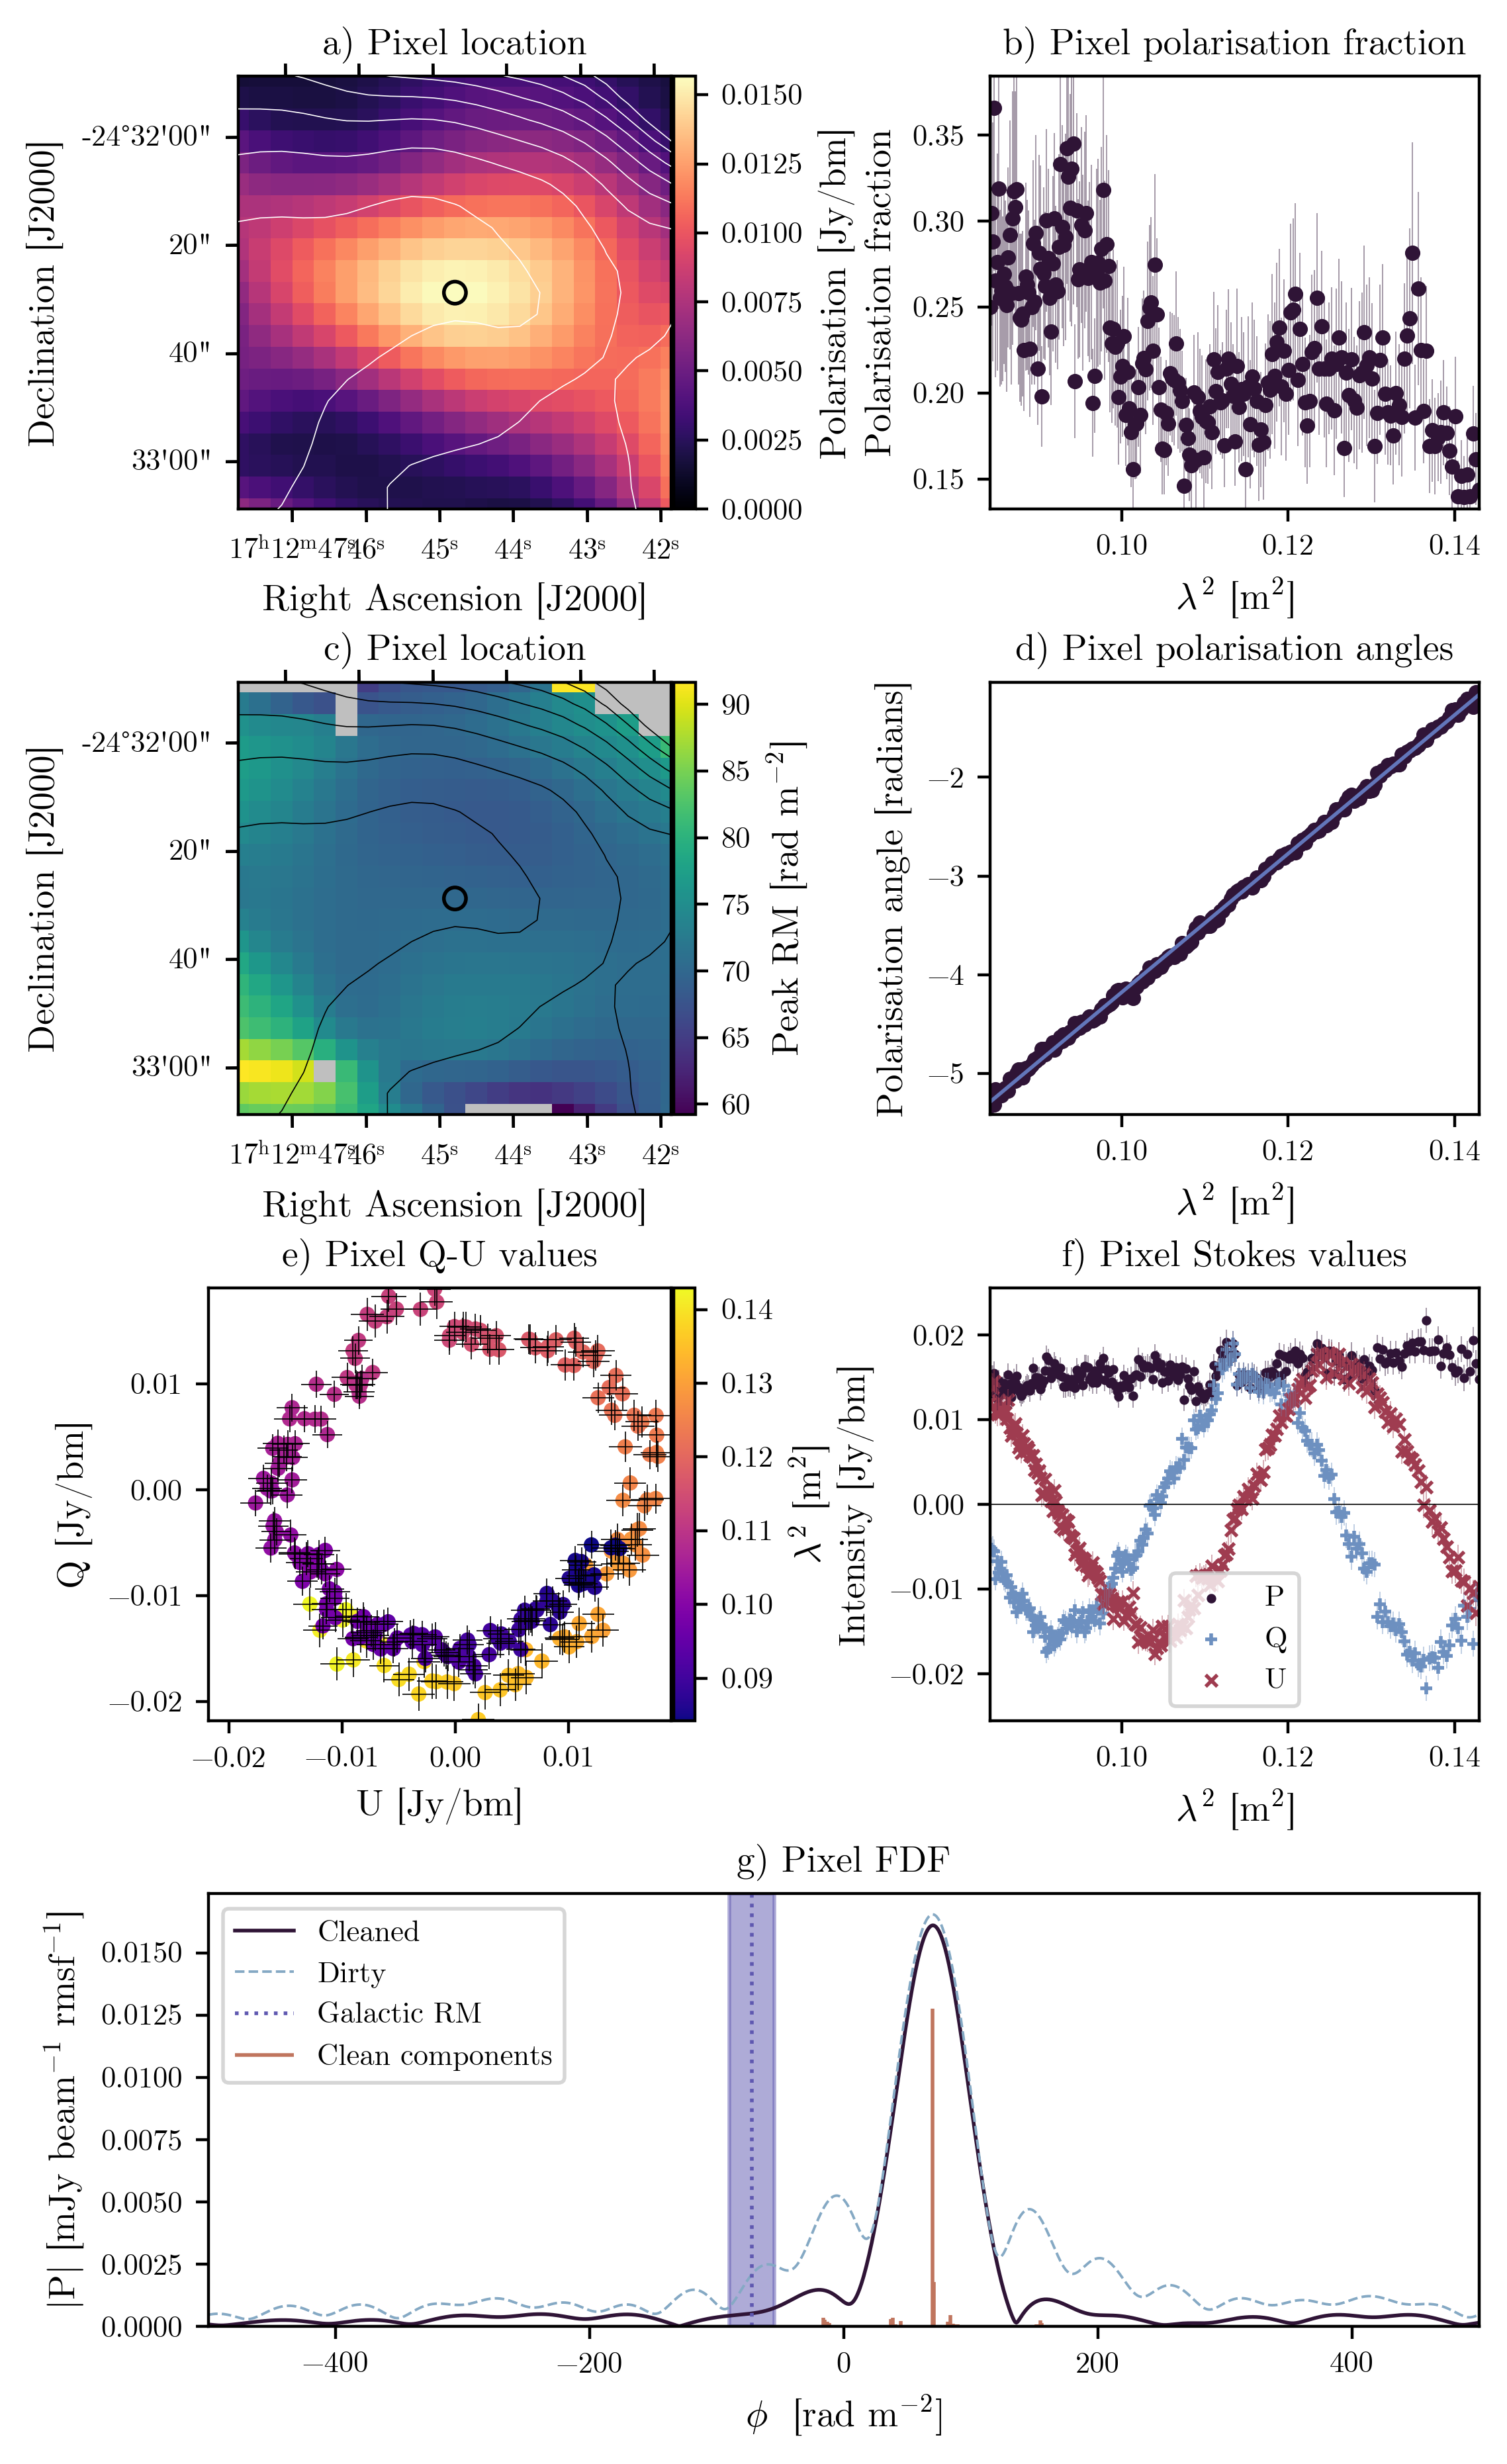

In [4]:
#find the most polarised pixel and do example plots:
exampley,examplex=np.unravel_index(np.nanargmax(average_p_map), average_p_map.shape)
#you can also just set pixel coordinates here that you want to look at 
#examplex,exampley=92,74

#grab the galactic RM values
examplecoords=utils.pixel_to_skycoord(xp=examplex,yp=exampley,wcs=wcs)
galacticRM,gRMerr=galactic_rm(examplecoords,galacicRMfile,galacticRMerrs)

#get slices along the z axis for each pixel
slice_i=i_cube_data[:,exampley,examplex]
slice_q=q_cube_data[:,exampley,examplex]
slice_u=u_cube_data[:,exampley,examplex]
slice_p=p_cube[:,exampley,examplex]
slice_pa=pa_cube[:,exampley,examplex]
slice_pa_errs=pa_cube_errs[:,exampley,examplex]
slice_polfrac=polfrac_cube[:,exampley,examplex]
slice_polfrac_err=polfrac_cube_errs[:,exampley,examplex]

# not convinced this works but stop your polarisation angles from wrapping 
unwrapped = 2*np.copy(slice_pa) 
unwrapped[~np.isnan(unwrapped)] = 0.5*np.unwrap(unwrapped[~np.isnan(unwrapped)],discont=-np.pi/2.)

#unwrapped=np.copy(slice_pa) 
try:
    p_rad,pError_rad,redchisqrd_rad=fit(lamdasq,unwrapped,slice_pa_errs+0.001)
except:
    print("uh oh")

examplerm=pkrm_fit_masked[exampley,examplex]
examplermerr=RMerr_arr[exampley,examplex]
print('Example RM={:+.1f}'.format(examplerm))
print("Making plots")

# put things together

# extract clean components to display 
clean_lines=np.where(np.abs(clean_components[:,exampley,examplex])>0,rmarray,np.nan)
clean_lines_max=np.where(np.abs(clean_components[:,exampley,examplex])>0,clean_components[:,exampley,examplex],np.nan)
clean_lines_min=np.where(np.abs(clean_components[:,exampley,examplex])>0,0,np.nan)

#start plotting 
fig=plt.figure(dpi=400,figsize=(6,10))

examplesquare=10 #sets the size of the viewing window in pixels 

# map of the average polarisd intensity around example pixel
ax1=plt.subplot(421,projection=wcs,adjustable='box')
ax1im=ax1.imshow(average_p_map, origin='lower', cmap=magmacmap,vmin=0,vmax=np.nanmax(average_p_map[exampley-examplesquare:exampley+examplesquare,examplex-examplesquare:examplex+examplesquare]))
ax1.contour(cont_im,levels=i_contours,colors='white')
ax1.scatter(examplex,exampley,marker='o',edgecolor='black',facecolor='none')
ax1.set_xlim(examplex-examplesquare,examplex+examplesquare)
ax1.set_ylim(exampley-examplesquare,exampley+examplesquare)
ax1.set_xlabel('Right Ascension [J2000]')
ax1.set_ylabel('Declination [J2000]')
cbar1=plt.colorbar(ax1im,fraction=0.0475, pad=0.005)
cbar1.ax.set_ylabel('Polarisation [Jy/bm]')
ax1.set_title('a) Pixel location')	

rm_cut_a=pkrm_fit_masked[exampley-examplesquare:exampley+examplesquare,examplex-examplesquare:examplex+examplesquare]
absrm=np.abs(rm_cut_a)
rm_cut=rm_cut_a[absrm<=200]
absrm_cut=absrm[absrm<=200]

rm_min=np.nanmin(rm_cut)
rm_max=np.nanmax(rm_cut)

# map of the peak RM around example pixel
ax2=plt.subplot(423,projection=wcs,adjustable='box')
ax2im=ax2.imshow(pkrm_fit_masked, origin='lower', cmap=plt.cm.viridis,vmin=rm_min,vmax=rm_max)
ax2.contour(cont_im,levels=i_contours,colors='black')
ax2.scatter(examplex,exampley,marker='o',edgecolor='black',facecolor='none')
ax2.set_xlim(examplex-examplesquare,examplex+examplesquare)
ax2.set_ylim(exampley-examplesquare,exampley+examplesquare)
ax2.set_xlabel('Right Ascension [J2000]')
ax2.set_ylabel('Declination [J2000]')
cbar2=plt.colorbar(ax2im,fraction=0.0475, pad=0.005)
cbar2.ax.set_ylabel(r'Peak RM [rad m$^{-2}$]')
ax2.set_title('c) Pixel location')#,\n RM value = {:+.1f}'.format(examplerm)+r'$\,\pm\,$'+'{:.1f}'.format(examplermerr)+r' rad m$^{-2}$')
print(r'RM value (synthesis) = {:+.1f}'.format(examplerm)+r'$\,\pm\,$'+'{:.1f}'.format(examplermerr)+r' rad m$^{-2}$')


# Plot of P Q and U vs lambda squared
ax3=plt.subplot(426,adjustable='box')
ax3.errorbar(lamdasq,slice_p,QUrms,linestyle="None",color=twilight(0.5),alpha=0.5)
ax3.errorbar(lamdasq,slice_q,QUrms,linestyle="None",color=twilight(0.2),alpha=0.5)
ax3.errorbar(lamdasq,slice_u,QUrms,linestyle="None",color=twilight(0.7),alpha=0.5)
ax3.scatter(lamdasq,slice_p,label='P',marker='.',color=twilight(0.5),s=10)
ax3.scatter(lamdasq,slice_q,label='Q',marker='+',linewidth=1,color=twilight(0.2),s=10)
ax3.scatter(lamdasq,slice_u,label='U',marker='x',linewidth=1,color=twilight(0.7),s=10)
ax3.axhline(y=0,color='k')
ax3.set_xlim(np.nanmin(lamdasq),np.nanmax(lamdasq))
ax3.set_xlabel(r'$\lambda^2$ [m$^2$]')
ax3.set_ylabel('Intensity [Jy/bm]')
ax3.set_title('f) Pixel Stokes values')
ax3.legend()

if np.nanmax(slice_polfrac)>=1:
    ymax_polfrac=1
else:
    ymax_polfrac=1.05*np.nanmax(slice_polfrac)

if np.nanmin(slice_polfrac)<=0:
    ymin_polfrac=0
else:
    ymin_polfrac=0.95*np.nanmin(slice_polfrac)

# polarisation fraction as a function of lambda squared
ax4=plt.subplot(422,adjustable='box')
ax4.scatter(lamdasq,slice_polfrac,color=twilight(0.5),s=10)
ax4.errorbar(lamdasq,slice_polfrac,slice_polfrac_err,color=twilight(0.5),linestyle='none',alpha=0.5)
ax4.set_xlim(np.nanmin(lamdasq),np.nanmax(lamdasq))
ax4.set_ylim(ymin_polfrac,ymax_polfrac)
ax4.set_xlabel(r'$\lambda^2$ [m$^2$]')
ax4.set_ylabel('Polarisation fraction')
ax4.set_title('b) Pixel polarisation fraction')


# QU spiral plot
qu_plot_min=np.nanmin([slice_u,slice_q])-0.0001
qu_plot_max=np.nanmax([slice_u,slice_q])+0.0001
ax5=plt.subplot(425,adjustable='box')
ax5im=ax5.scatter(slice_u,slice_q,c=lamdasq,cmap=plt.cm.plasma,s=10)
ax5.errorbar(slice_u,slice_q,xerr=U_cube_rms,yerr=Q_cube_rms,linestyle='none',color='k')
ax5.set_xlabel('U [Jy/bm]')
ax5.set_ylabel('Q [Jy/bm]')
ax5.set_xlim(qu_plot_min,qu_plot_max)
ax5.set_ylim(qu_plot_min,qu_plot_max)
#ax5.set_aspect('equal')
cbar5=plt.colorbar(ax5im,fraction=0.048, pad=0.005)
cbar5.ax.set_ylabel(r'$\lambda^2$ [m$^2$]')
ax5.set_title('e) Pixel Q-U values')

# polarisation angle vs lambda sq
ax6=plt.subplot(424,adjustable='box')
#ax6.scatter(lamdasq,slice_pa,color='b')
#ax6.errorbar(lamdasq,slice_pa,slice_pa_errs,linestyle='None',color='b')
ax6.scatter(lamdasq,unwrapped,color=twilight(0.5),s=10)
ax6.errorbar(lamdasq,unwrapped,slice_pa_errs,linestyle='None',color=twilight(0.5),alpha=0.5)
ax6.plot(lamdasq,(p_rad[0]*lamdasq+p_rad[1]),linewidth=1,color=twilight(0.25))
ax6.set_xlabel(r'$\lambda^2$ [m$^2$]')
ax6.set_ylabel('Polarisation angle [radians]')
ax6.set_xlim(np.nanmin(lamdasq),np.nanmax(lamdasq))
ax6.set_ylim(np.nanmin(unwrapped)-0.1,np.nanmax(unwrapped)+0.1)
#plt.annotate(text='{:+.1f}'.format(p_rad[0])+r'$\,\pm\,$'+'{:.1f}'.format(pError_rad[0])+r' rad m$^{-2}$',xy=(0.64,0.45),xycoords='figure fraction',color='k',fontsize=SMALL_SIZE)
ax6.set_title('d) Pixel polarisation angles')#,\n RM value = {:+.1f}'.format(p_rad[0])+r'$\,\pm\,$'+'{:.1f}'.format(pError_rad[0])+r' rad m$^{-2}$')
print(r'RM value (angle fit) = {:+.1f}'.format(p_rad[0])+r'$\,\pm\,$'+'{:.1f}'.format(pError_rad[0])+r' rad m$^{-2}$')
ax7=plt.subplot(414)

# FDF plot
ax7.plot(rmarray,fdf_clean[:,exampley,examplex],label='Cleaned',linewidth=1,color=twilight(0.5))
ax7.plot(rmarray,fdfdata[:,exampley,examplex],label='Dirty',linestyle='dashed',linewidth=0.7,color=twilight(0.15))
#ax7.axhline(y=0,color='k')
ax7.vlines(clean_lines,clean_lines_min,clean_lines_max,color=twilight(0.8),linewidth=1,label='Clean components')
ax7.set_ylabel(r'|P| [mJy beam$^{-1}$ rmsf$^{-1}$]')
ax7.set_xlabel(r'$\phi$  [rad m$^{-2}]$')
ax7.set_xlim(-500,500)
ymaxfdf=1.05*np.nanmax(fdfdata[:,exampley,examplex])
ax7.set_ylim(0,ymaxfdf)
ax7.axvline(x=galacticRM,color=twilight(0.3),linestyle=':',linewidth=1,label='Galactic RM')
ax7.fill_betweenx([0,ymaxfdf],x1=galacticRM-gRMerr, x2=galacticRM+gRMerr,color=twilight(0.3),alpha=0.5)
ax7.legend(loc='upper left')
ax7.set_title('g) Pixel FDF')

#adjust limits and show
plt.subplots_adjust(left=0.15, bottom=0.1, right=0.95, top=0.95, wspace=0.6, hspace=0.4)
#plt.subplots_adjust(left=0.15, bottom=0.1, right=0.95, top=0.95, wspace=0.6, hspace=0.35)
if savefigs:
    plt.savefig(fig_directory+src+'_example_pix{}_{}'.format(examplex,exampley)+'.png',dpi=400,bbox_inches='tight',transparent=True)
    plt.savefig(directory+src+'_example_pix{}_{}'.format(examplex,exampley)+'.png',dpi=400,bbox_inches='tight',transparent=True)
plt.show()

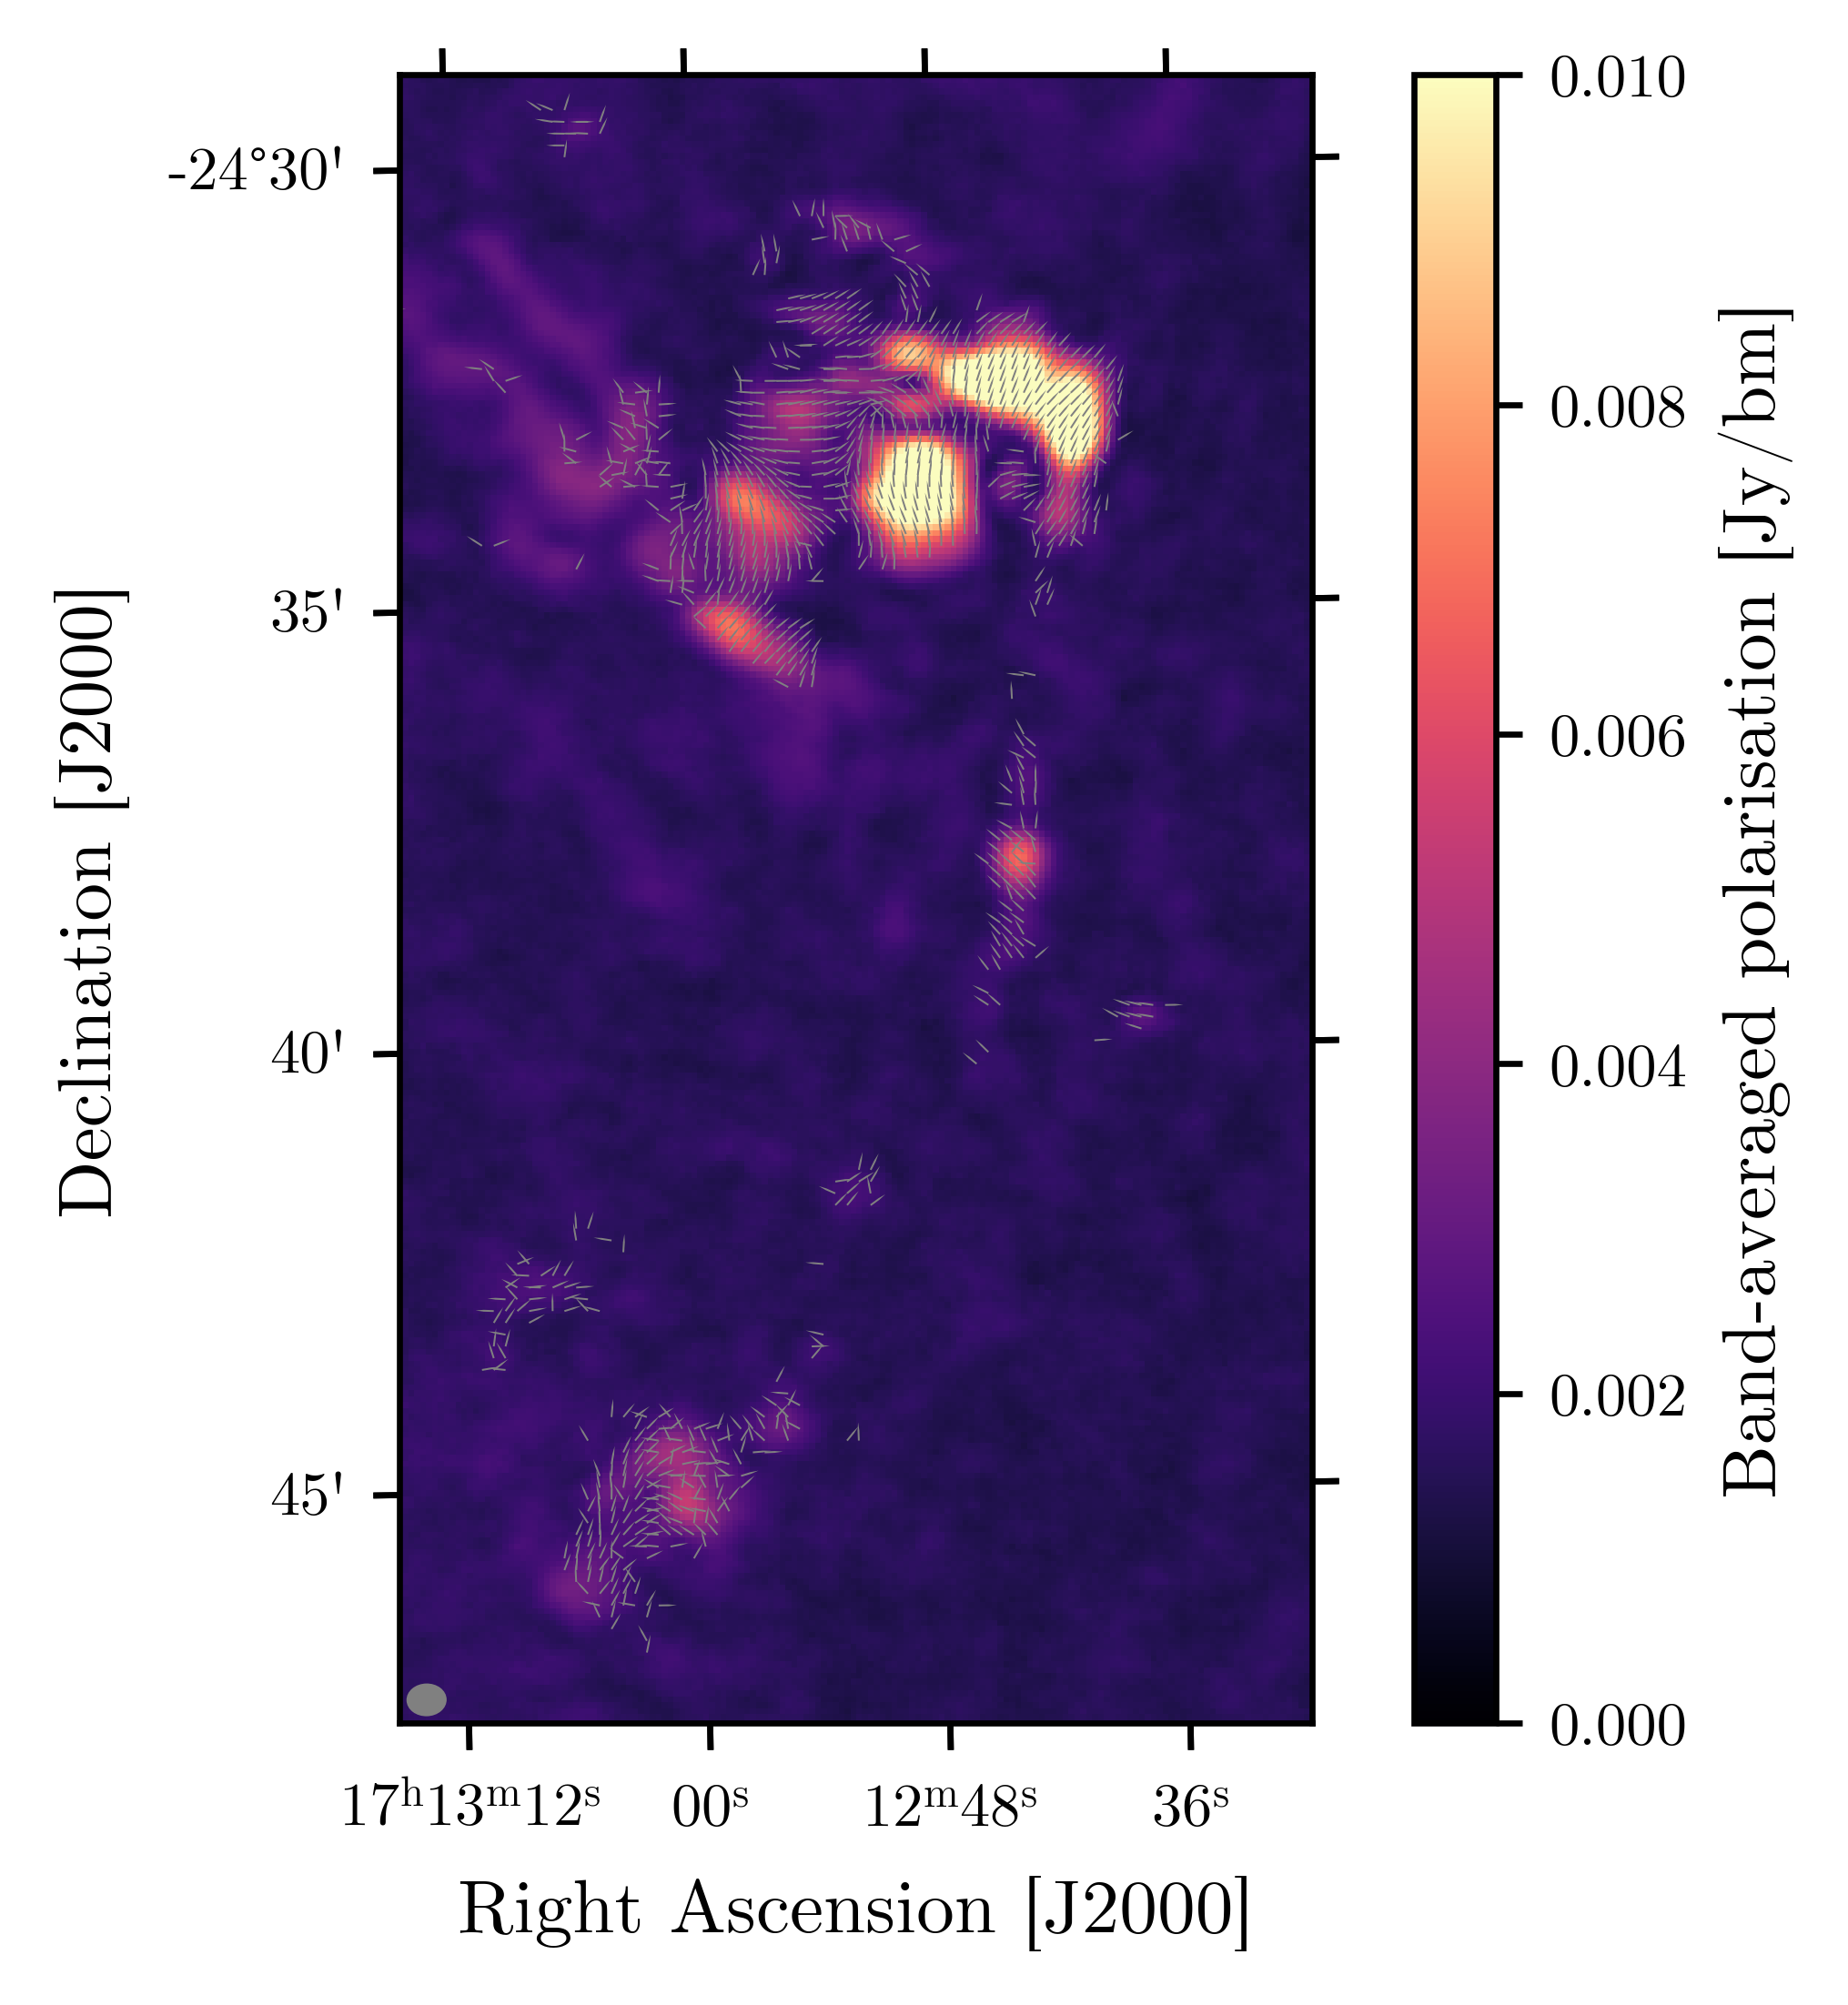

In [5]:
# Polarisation map with intrinsic polarisation vectors
chi_0_fdf_deg=np.rad2deg(chi0_fit_masked)
x=np.cos(np.deg2rad(chi_0_fdf_deg+90))
y=np.sin(np.deg2rad(chi_0_fdf_deg+90))

shortest_axis=np.nanmin([xmax-xmin,ymax-ymin])
step=int(np.floor(shortest_axis/100.))
if step <= 2:
    step=2

# reduce the number of vectors plotted (if one was plotted on every pixel it would be too much!!)
x_reduced=x[0::step,0::step]
y_reduced=y[0::step,0::step]
x_pos=np.arange(start=0,stop=x.shape[1],step=step)
y_pos=np.arange(start=0,stop=x.shape[0],step=step)

pol_angle_mask=average_p_map_masked.mask[0::step,0::step]

x_reduced=np.where(pol_angle_mask==1,np.nan,x_reduced)
y_reduced=np.where(pol_angle_mask==1,np.nan,y_reduced)

plt.figure(dpi= 600)
ax=plt.subplot(projection=wcs)
c=ax.imshow(average_p_map, origin='lower', cmap=magmacmap,vmin=0,vmax=0.01)#norm=colors.LogNorm(vmin=0.001,vmax=0.01))#,vmin=0,vmax=vmax(average_p_map_masked,99.99))
q = ax.quiver(x_pos,y_pos,x_reduced,y_reduced,color='gray',scale=50,width=0.002,headlength=0,headwidth=0)
#ax.contour(cont_im,levels=i_contours,colors='black')
plt.xlabel('Right Ascension [J2000]')
plt.ylabel('Declination [J2000]')
plt.gca().set_aspect("equal")
ellipse= Ellipse(xy=(posx,posy),width=bmaj_pix,height=bmin_pix,angle=bpa+90,edgecolor='gray',fc='gray',lw=0.5)
ax.add_patch(ellipse)
cbar=plt.colorbar(c,fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Band-averaged polarisation [Jy/bm]')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
if savefigs:
    plt.savefig(fig_directory+src+'_avpol_quiver.png',dpi=400,bbox_inches='tight',transparent=True)
    plt.savefig(directory+src+'_avpol_quiver.png',dpi=400,bbox_inches='tight',transparent=True)
plt.show()

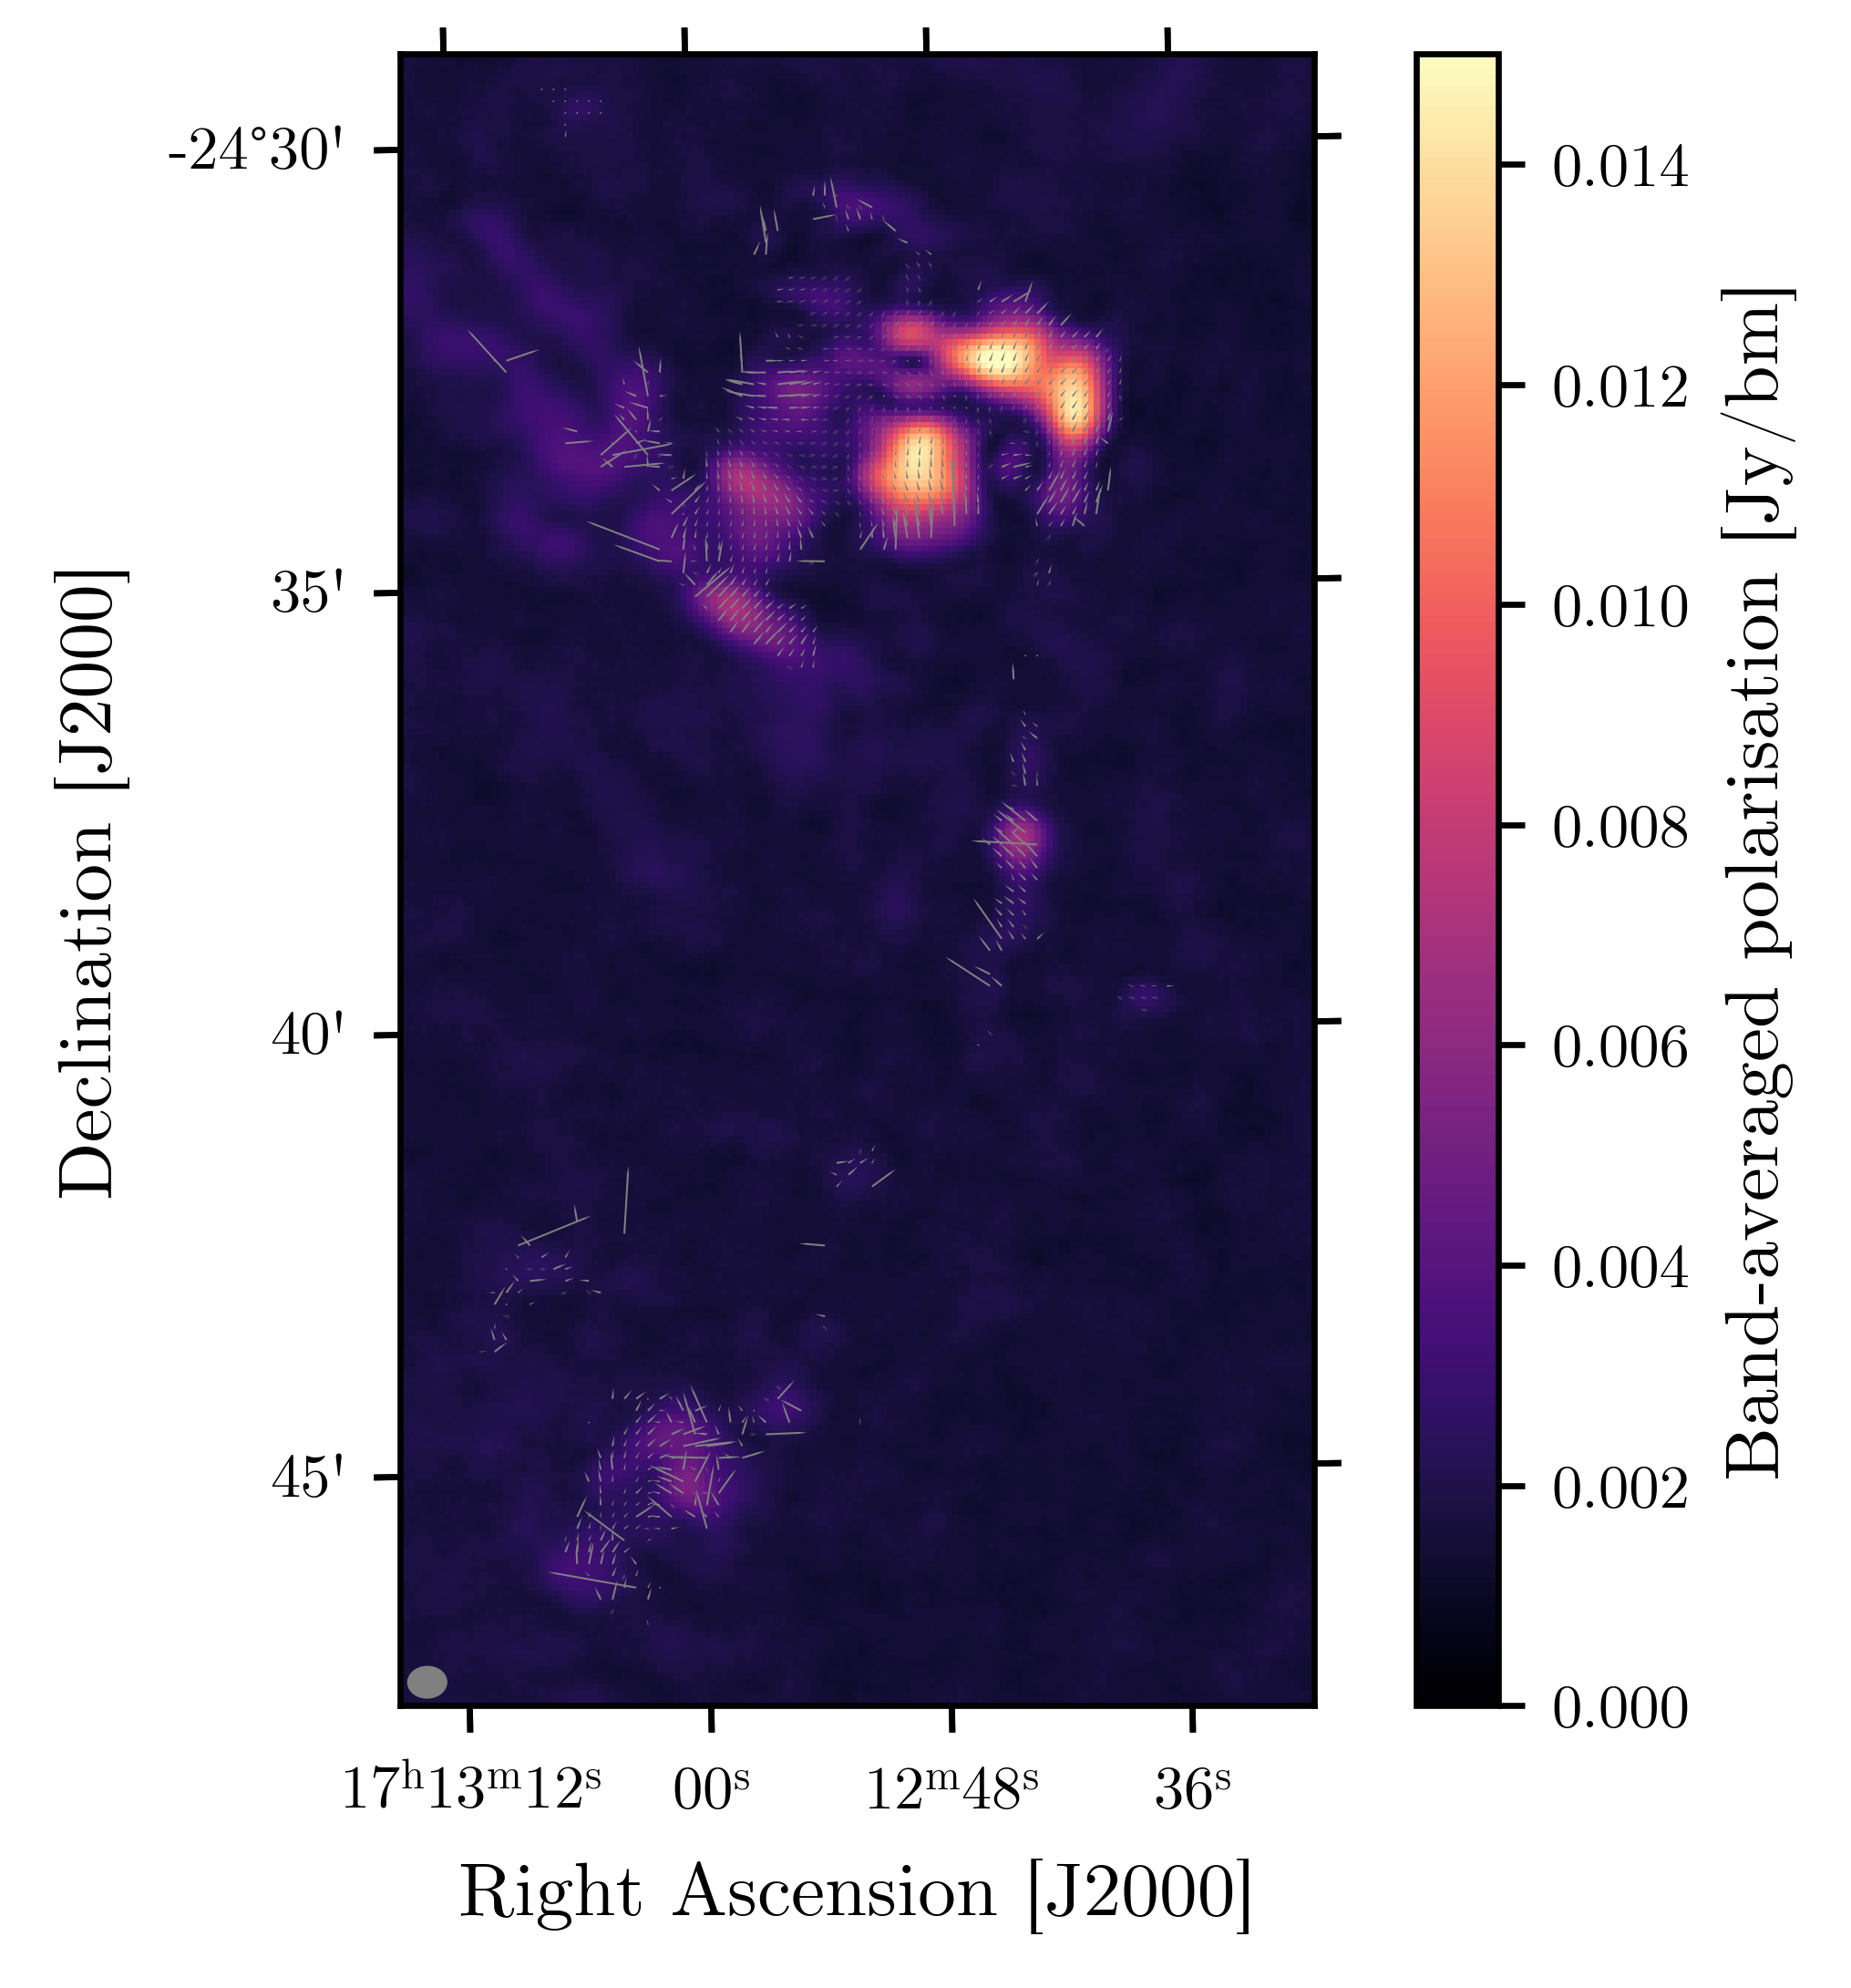

In [46]:

polfrac_reduced=polfrac_map_masked[0::step,0::step]
x_scaled=np.multiply(x_reduced,polfrac_reduced)
y_scaled=np.multiply(y_reduced,polfrac_reduced)

plt.figure(dpi= 600)
ax=plt.subplot(projection=wcs)
c=ax.imshow(average_p_map, origin='lower', cmap=magmacmap,vmin=0,vmax=0.015)#norm=colors.LogNorm(vmin=0.001,vmax=0.01))#,vmin=0,vmax=vmax(average_p_map_masked,99.99))
q = ax.quiver(x_pos,y_pos,x_scaled,y_scaled,scale=20,color='gray',width=0.002,headlength=0,headwidth=0)
#ax.contour(cont_im,levels=i_contours,colors='black')
plt.xlabel('Right Ascension [J2000]')
plt.ylabel('Declination [J2000]')
plt.gca().set_aspect("equal")
ellipse= Ellipse(xy=(posx,posy),width=bmaj_pix,height=bmin_pix,angle=bpa+90,edgecolor='gray',fc='gray',lw=0.5)
ax.add_patch(ellipse)
cbar=plt.colorbar(c,fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Band-averaged polarisation [Jy/bm]')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
if savefigs:
    plt.savefig(fig_directory+src+'_avpol_quiver_fracpol.png',dpi=400,bbox_inches='tight',transparent=True)
    plt.savefig(directory+src+'_avpol_quiver_fracpol.png',dpi=400,bbox_inches='tight',transparent=True)
plt.show()

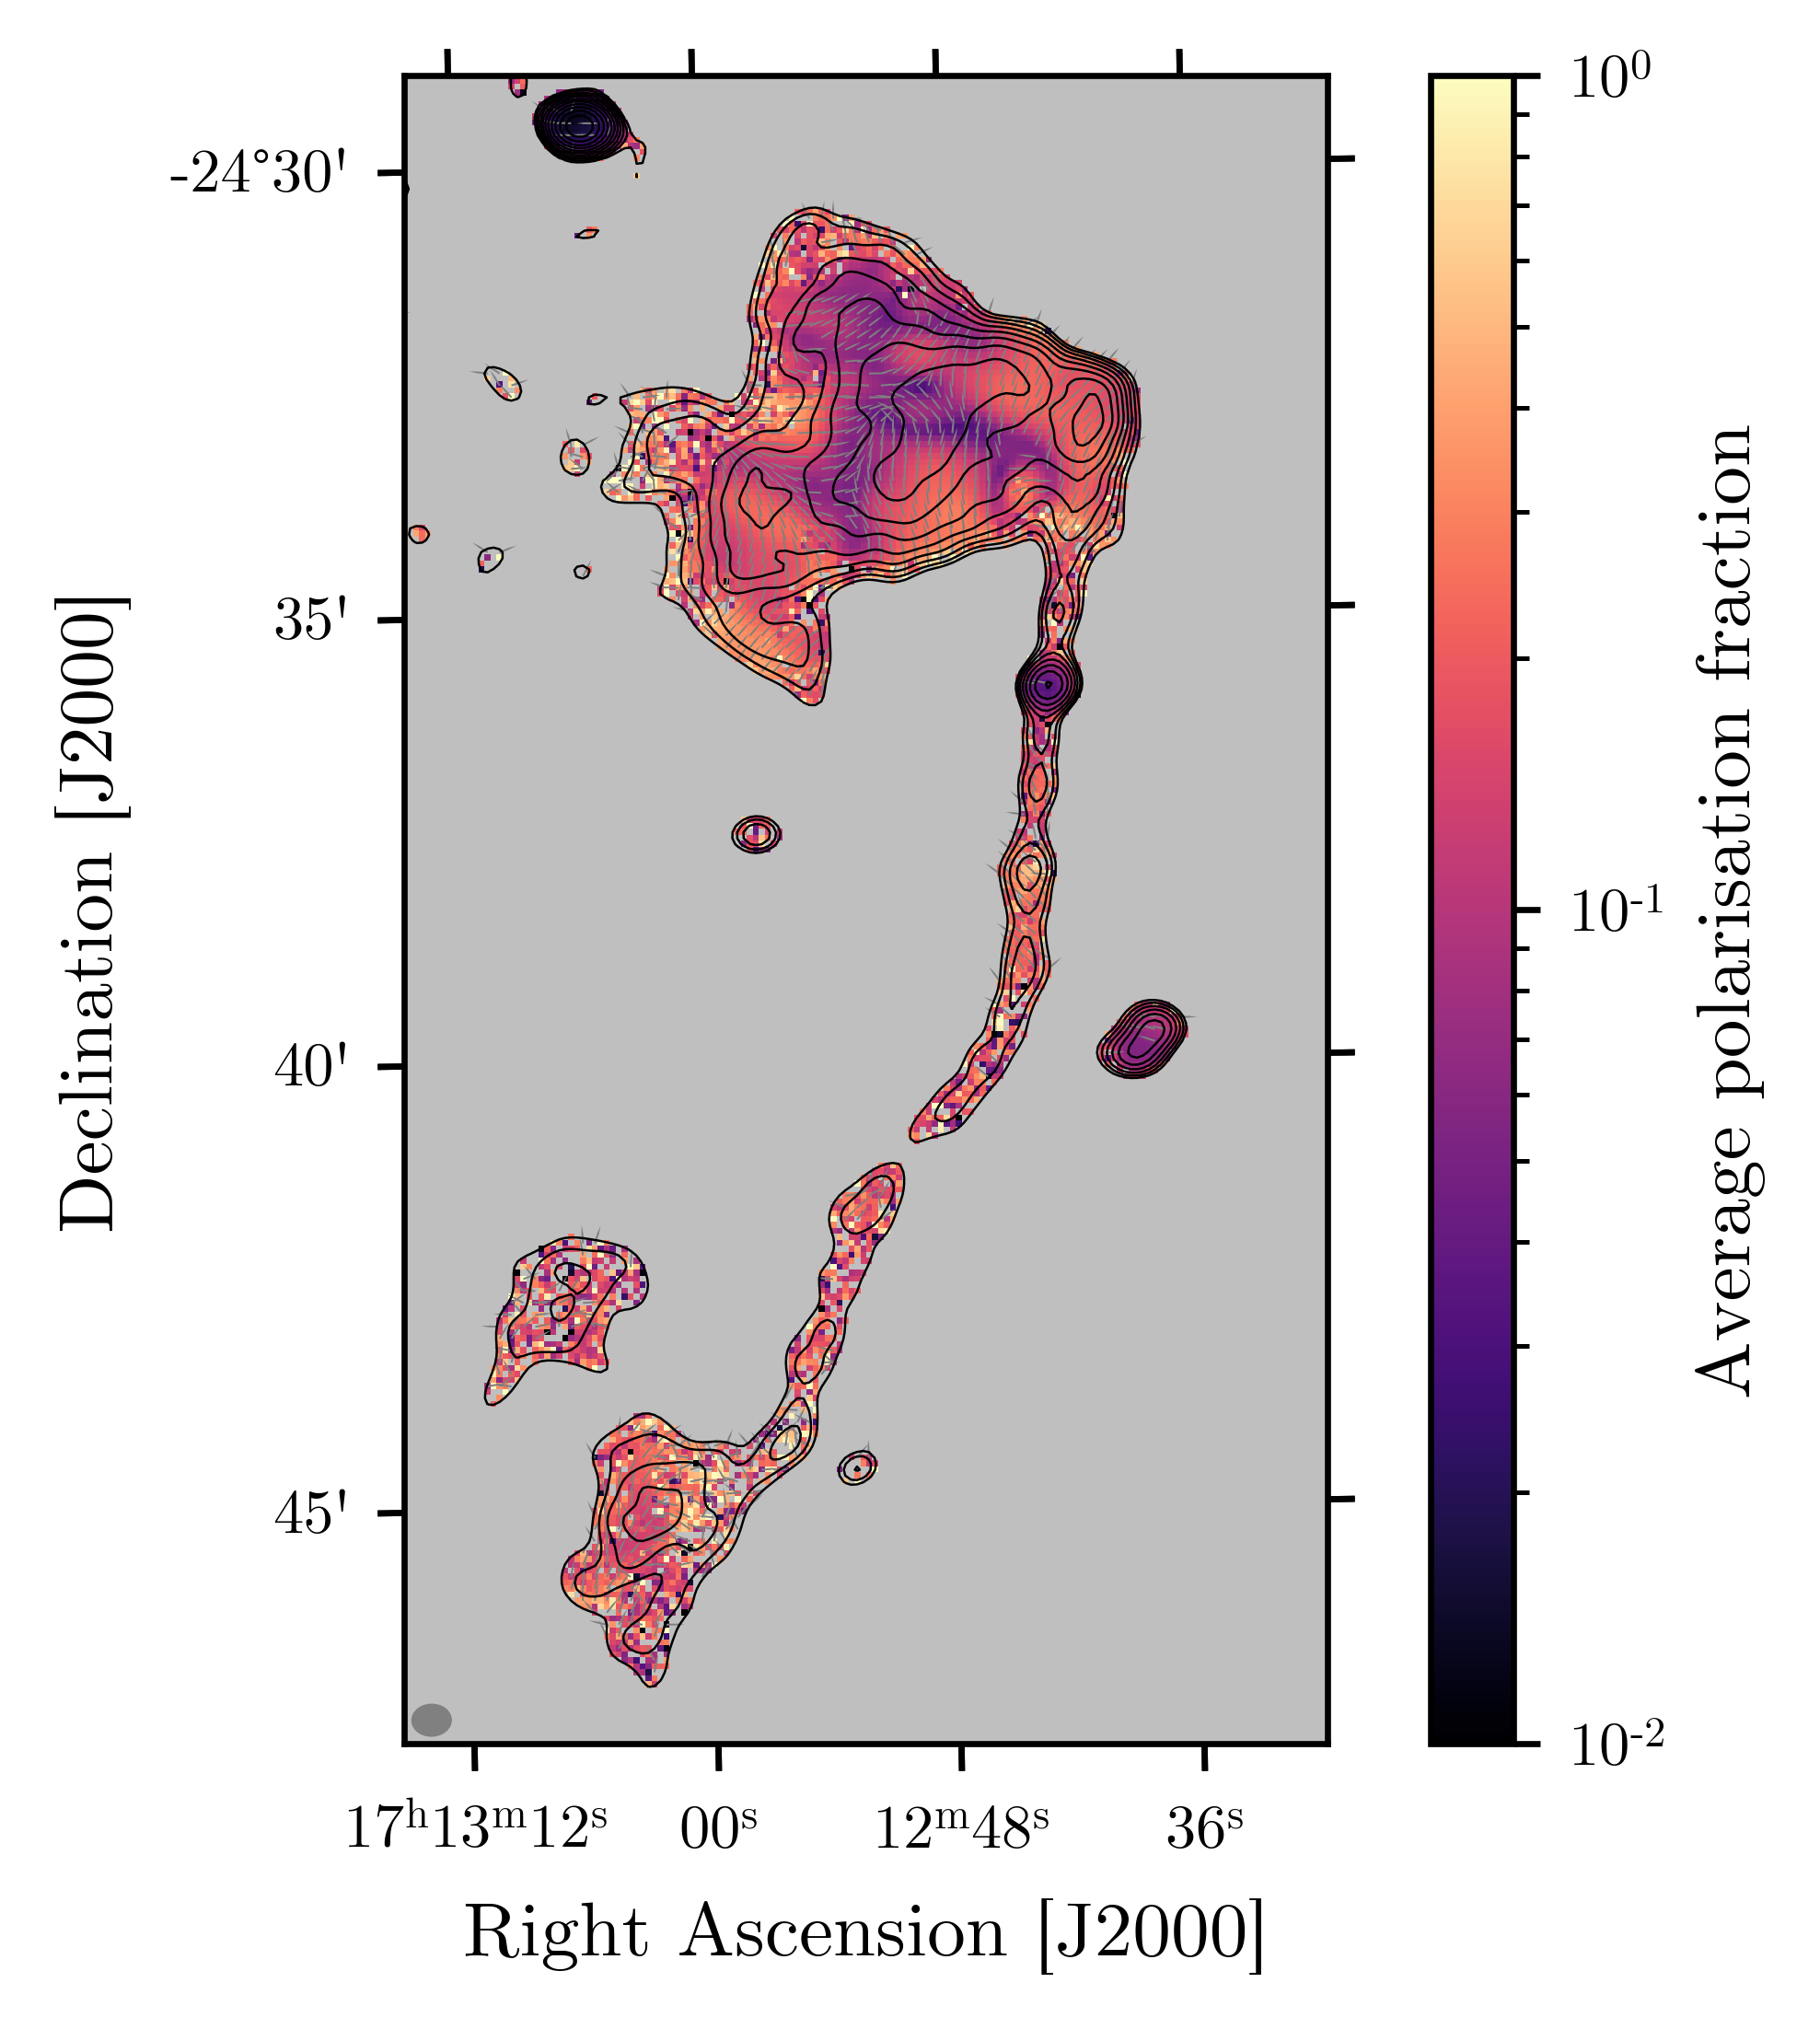

In [7]:
#polfrac
plt.figure(dpi= 600)
ax=plt.subplot(projection=wcs)
c=ax.imshow(polfrac_map_masked, origin='lower', cmap=magmacmap,norm=colors.LogNorm(vmin=0.01, vmax=1))#,vmin=0,vmax=1)
q = ax.quiver(x_pos,y_pos,x_reduced,y_reduced,color='gray',scale=50,width=0.002,headlength=0,headwidth=0)
ax.contour(cont_im,levels=i_contours,colors='black')
plt.xlabel('Right Ascension [J2000]')
plt.ylabel('Declination [J2000]')
plt.gca().set_aspect("equal")
ellipse= Ellipse(xy=(posx,posy),width=bmaj_pix,height=bmin_pix,angle=bpa+90,edgecolor='gray',fc='gray',lw=0.5)
ax.add_patch(ellipse)
cbar=plt.colorbar(c,fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Average polarisation fraction')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
if savefigs:
    plt.savefig(fig_directory+src+'_avpolfrac_quiver.png',dpi=400,bbox_inches='tight',transparent=True)
    plt.savefig(directory+src+'_avpolfrac_quiver.png',dpi=400,bbox_inches='tight',transparent=True)
plt.show()

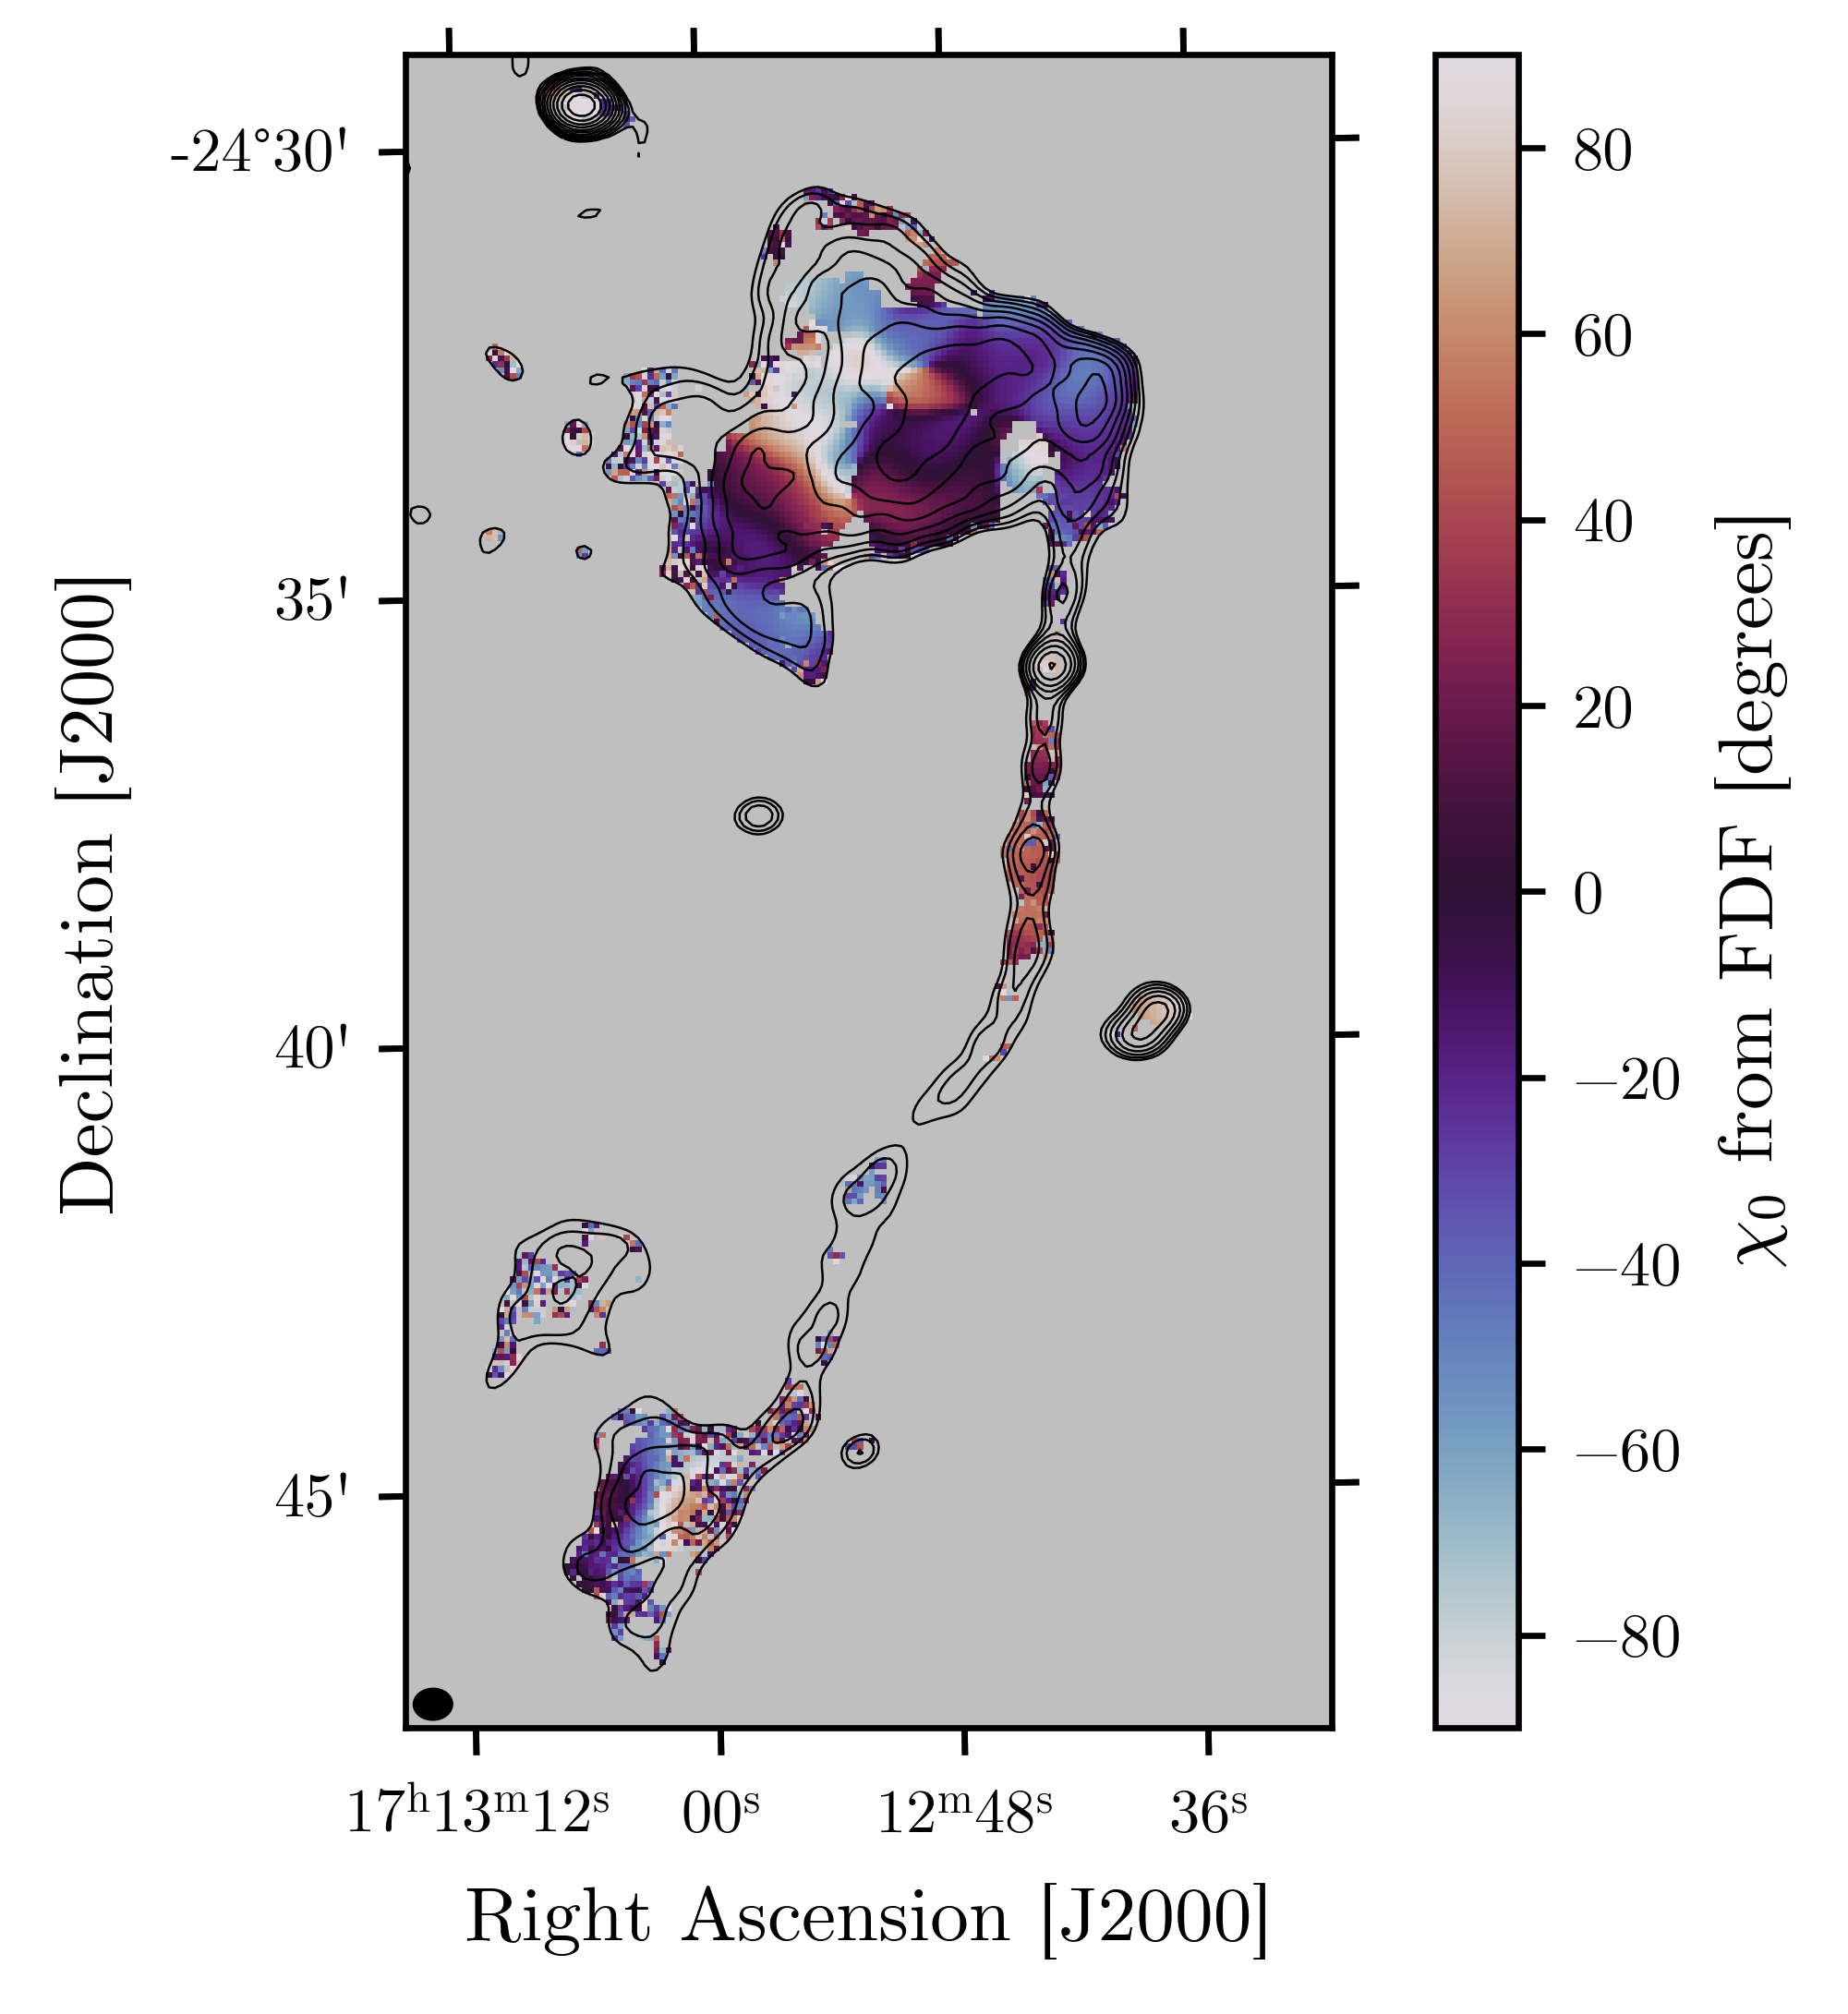

In [8]:
#chi 0 plot
chi_0_fdf_deg=np.where(pkrm_fit_masked.mask==True,np.nan,chi_0_fdf_deg)
plt.figure(dpi= 600)
ax=plt.subplot(projection=wcs)
c=ax.imshow(chi_0_fdf_deg, origin='lower', cmap=twilight,vmin=-90,vmax=90)
ax.contour(cont_im,levels=i_contours,colors='black')
plt.xlabel('Right Ascension [J2000]')
plt.ylabel('Declination [J2000]')
ellipse= Ellipse(xy=(posx,posy),width=bmaj_pix,height=bmin_pix,angle=bpa+90,edgecolor='black',fc='black',lw=0.5)
ax.add_patch(ellipse)
cbar=plt.colorbar(c,fraction=0.046, pad=0.04)
cbar.ax.set_ylabel(r'$\chi_0$ from FDF [degrees]')
plt.gca().set_aspect("equal")
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
if savefigs:
    plt.savefig(fig_directory+src+'_chi0',dpi=400,bbox_inches='tight',transparent=True)
    plt.savefig(directory+src+'_chi0',dpi=400,bbox_inches='tight',transparent=True)
plt.show()

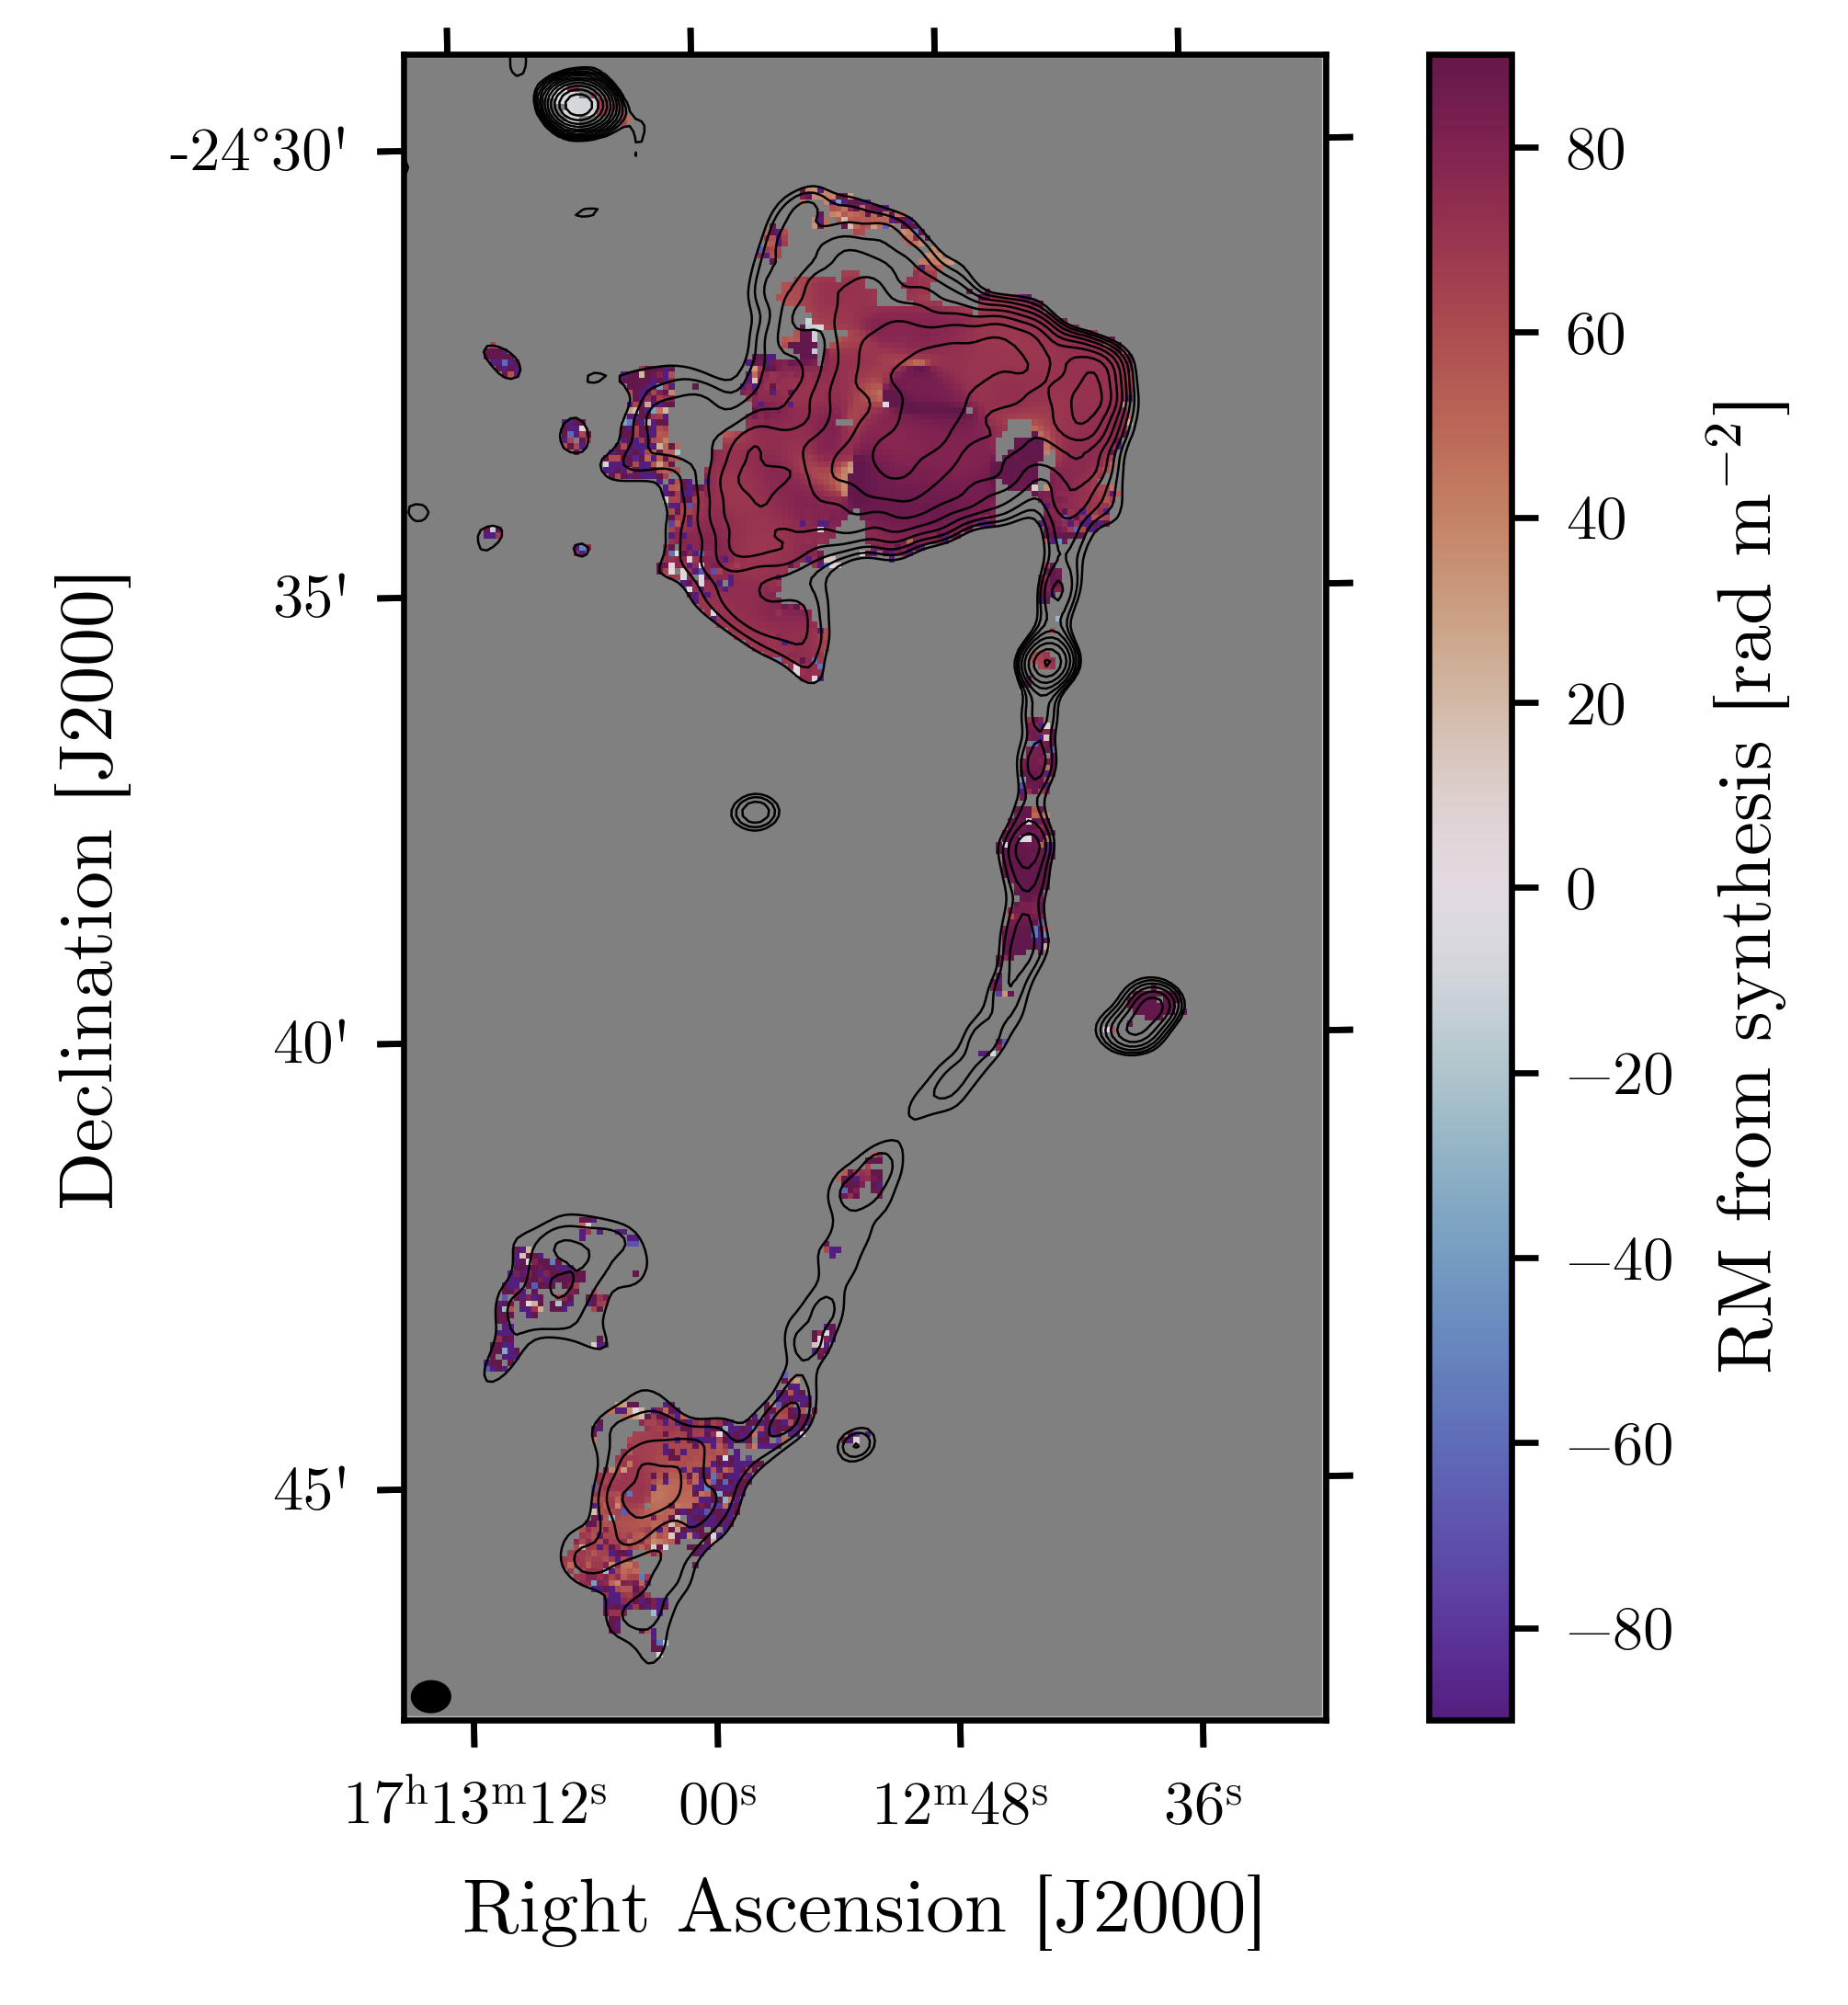

In [9]:
#I don't know why I need to do the followling line but here we are
pkrm_fit_masked=np.where(pkrm_fit_masked.mask==1,np.nan,pkrm_fit_masked)

plt.figure(dpi= 600)
ax=plt.subplot(projection=wcs)
c=ax.imshow(pkrm_fit_masked, origin='lower', cmap=cmap_redblue,vmin=-1*rm_scale,vmax=rm_scale)
ax.contour(cont_im,levels=i_contours,colors='black')
plt.xlabel('Right Ascension [J2000]')
plt.ylabel('Declination [J2000]')
ellipse= Ellipse(xy=(posx,posy),width=bmaj_pix,height=bmin_pix,angle=bpa+90,edgecolor='black',fc='black',lw=0.5)
ax.add_patch(ellipse)
ax.set_facecolor('grey')
cbar=plt.colorbar(c,fraction=0.046, pad=0.04)
cbar.ax.set_ylabel(r'RM from synthesis [rad m$^{-2}$]')
plt.gca().set_aspect("equal")
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
if savefigs:
    plt.savefig(fig_directory+src+'RM_peak_fitted.png',dpi=400,bbox_inches='tight',transparent=True)
    plt.savefig(directory+src+'RM_peak_fitted.png',dpi=400,bbox_inches='tight',transparent=True)
plt.show()

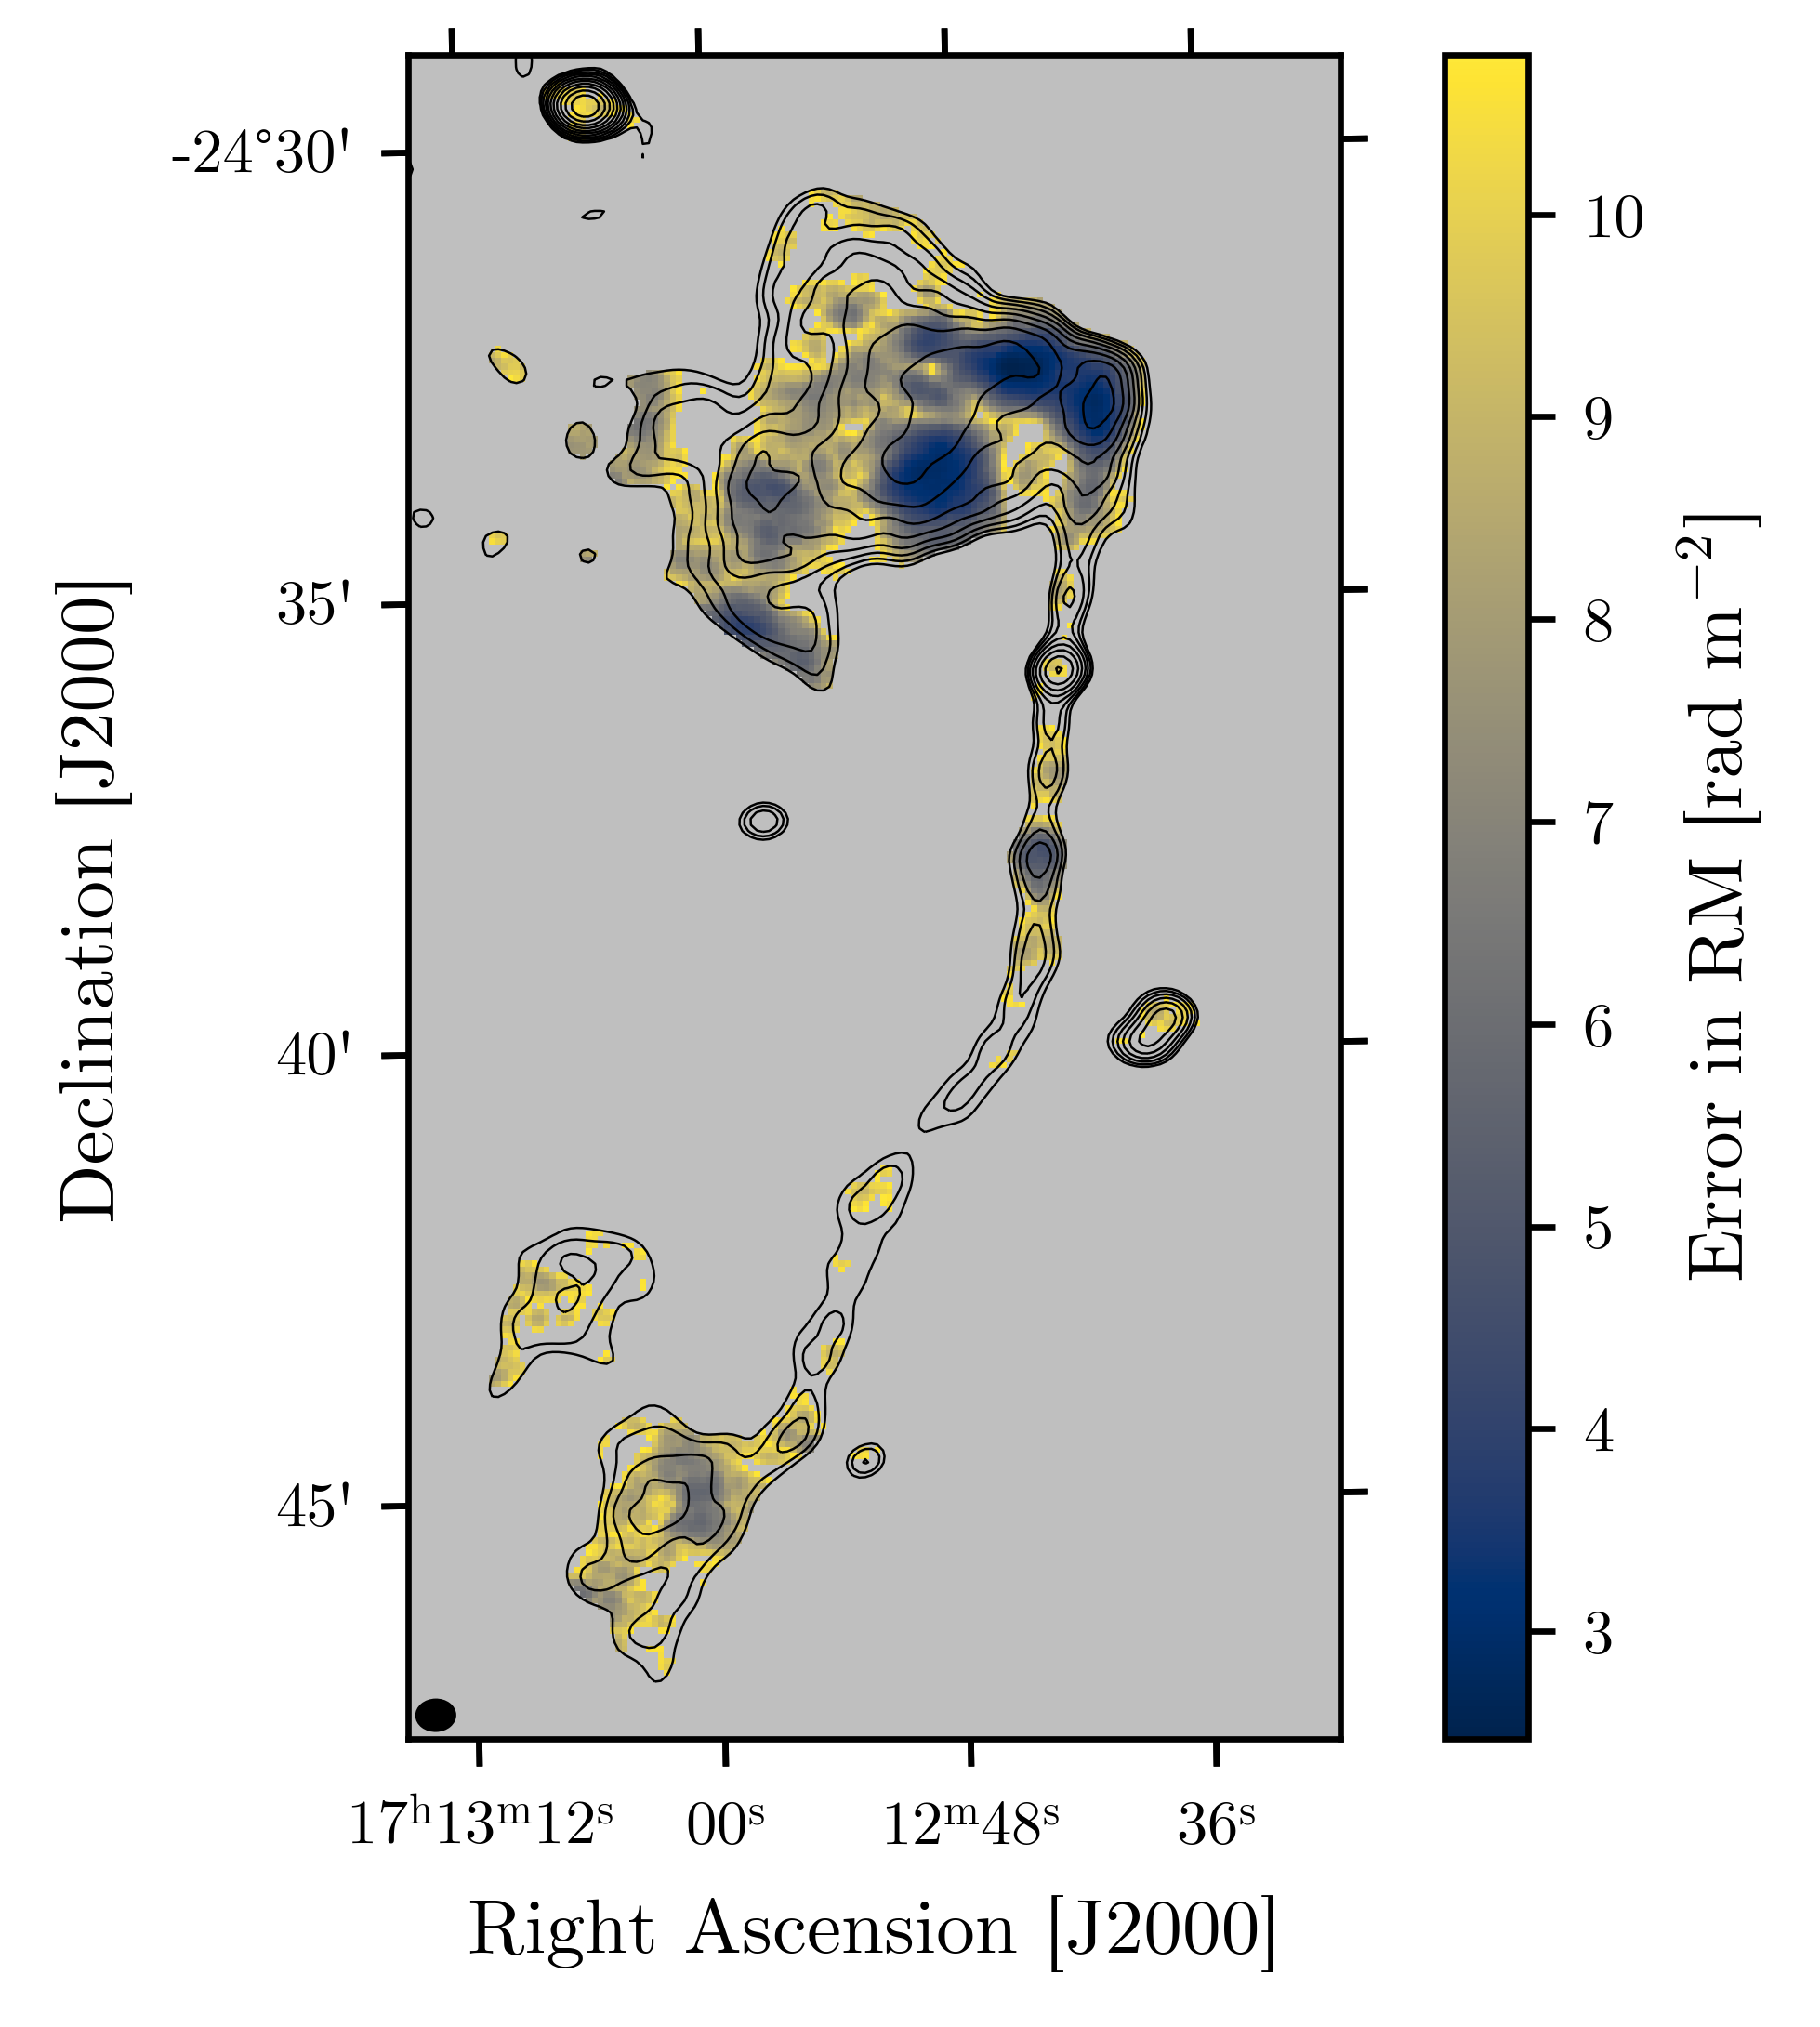

In [10]:
#rm serrs
RMerr_arr_masked=np.where(cont_pol_mask.mask==True,np.nan,RMerr_arr)
plt.figure(dpi= 600)
ax=plt.subplot(projection=wcs)
c=ax.imshow(RMerr_arr_masked, origin='lower', cmap=cividis)
ax.contour(cont_im,levels=i_contours,colors='black')
plt.xlabel('Right Ascension [J2000]')
plt.ylabel('Declination [J2000]')
ellipse= Ellipse(xy=(posx,posy),width=bmaj_pix,height=bmin_pix,angle=bpa+90,edgecolor='black',fc='black',lw=0.5)
ax.add_patch(ellipse)
cbar=plt.colorbar(c,fraction=0.046, pad=0.04)
cbar.ax.set_ylabel(r'Error in RM [rad m$^{-2}$]')
plt.gca().set_aspect("equal")
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
if savefigs:
    plt.savefig(fig_directory+src+'RM_peak_fitted_errs.png',dpi=400,bbox_inches='tight',transparent=True)
    plt.savefig(directory+src+'RM_peak_fitted_errs.png',dpi=400,bbox_inches='tight',transparent=True)
plt.show()

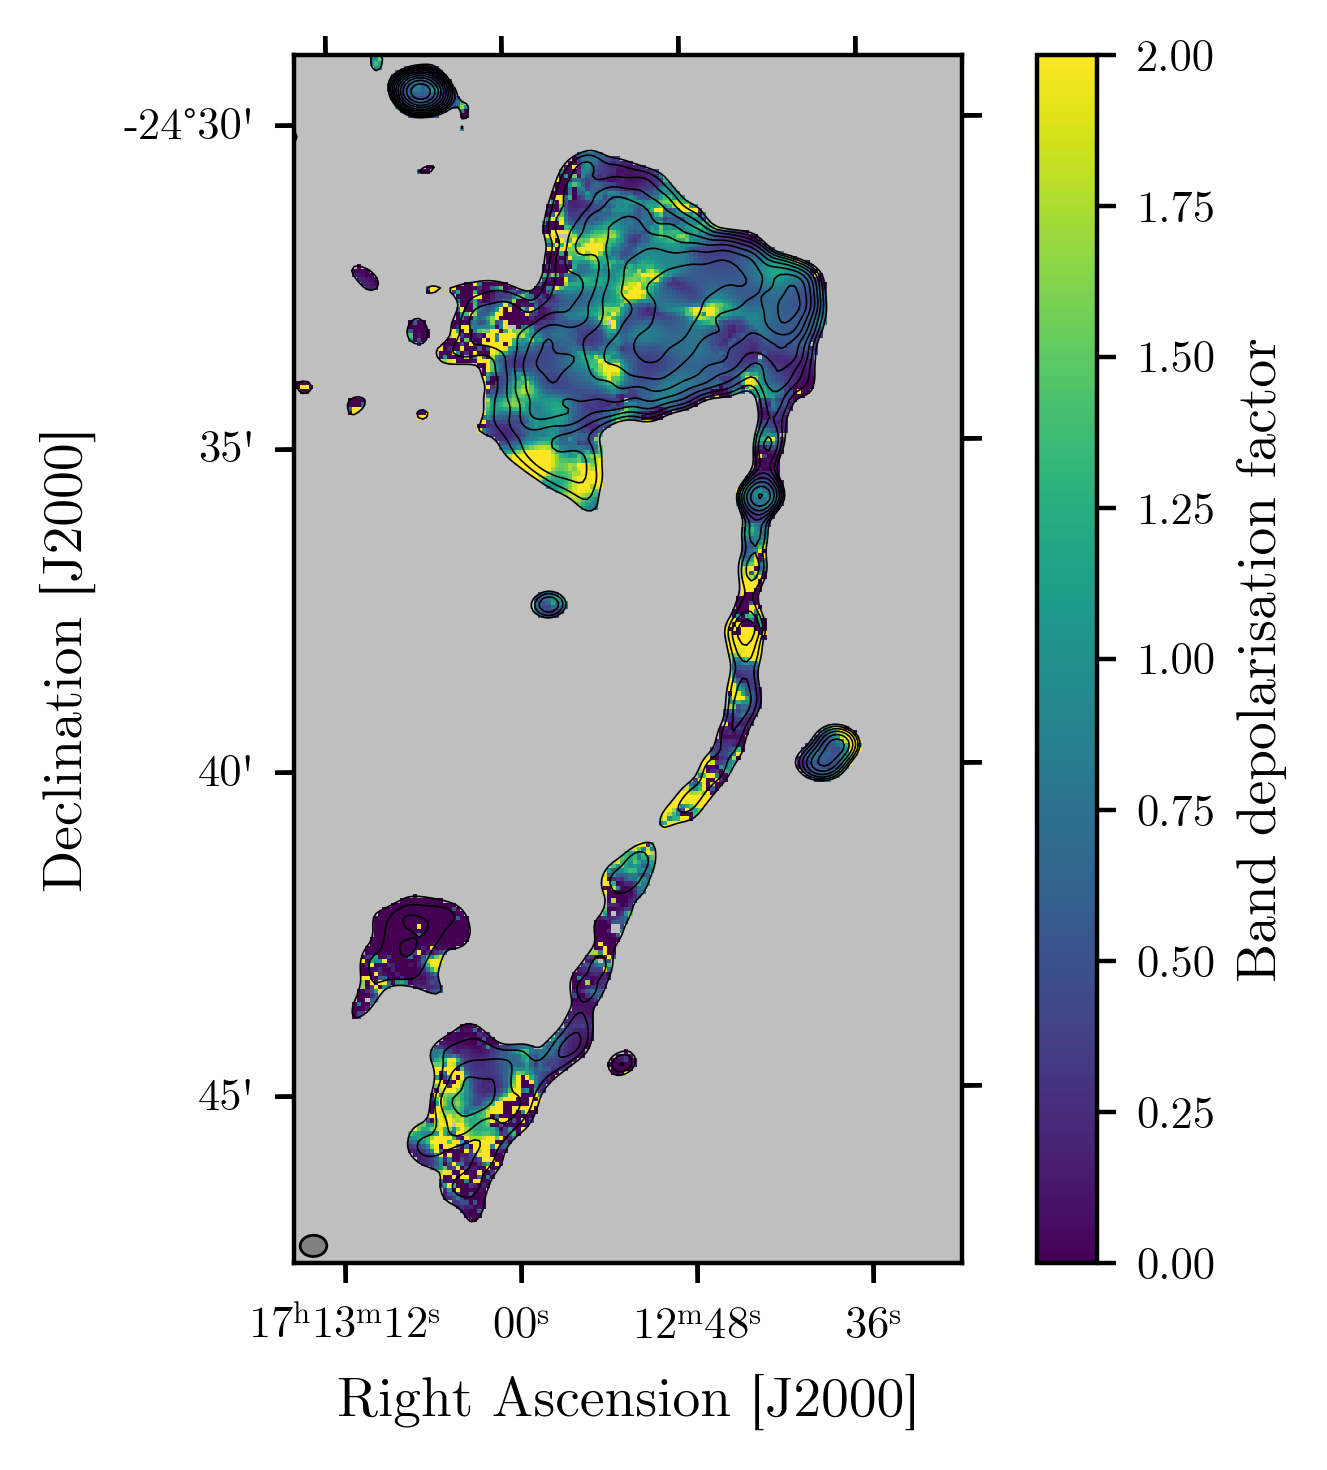

In [11]:
#polfrac change map
plt.figure(dpi= 400)
ax=plt.subplot(projection=wcs)
c=ax.imshow(polfrac_change_masked, origin='lower', cmap=viridis,vmin=0,vmax=2)
ax.contour(cont_im,levels=i_contours,colors='black')
plt.xlabel('Right Ascension [J2000]')
plt.ylabel('Declination [J2000]')
ellipse= Ellipse(xy=(posx,posy),width=bmaj_pix,height=bmin_pix,angle=bpa+90,edgecolor='black',fc='gray',lw=0.5)
ax.add_patch(ellipse)
cbar=plt.colorbar(c,fraction=0.046, pad=0.04)
cbar.ax.set_ylabel(r'Band depolarisation factor')
plt.gca().set_aspect("equal")
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
if savefigs:
    plt.savefig(fig_directory+src+'polfrac_change.png',dpi=400,bbox_inches='tight',transparent=True)
    plt.savefig(directory+src+'polfrac_change.png',dpi=400,bbox_inches='tight',transparent=True)
plt.show()

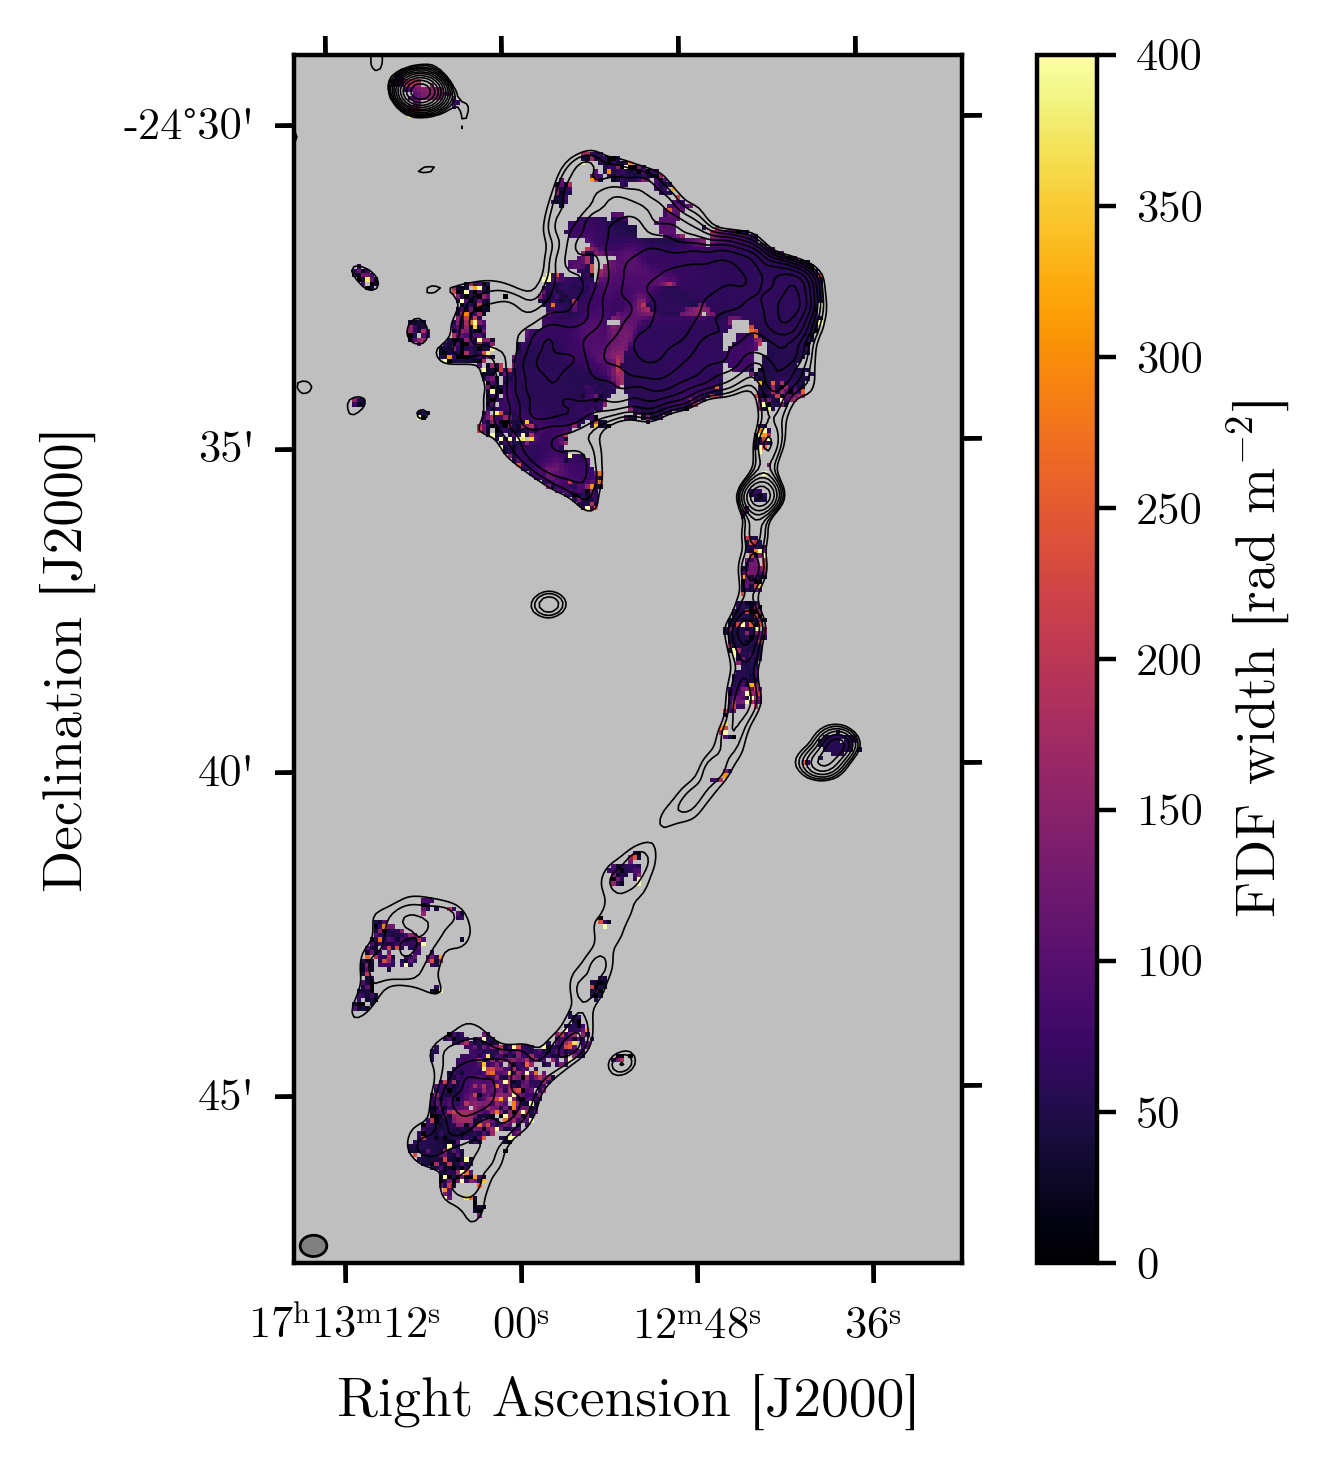

In [12]:
#width of peak in FDF
fdf_width=np.where(cont_pol_mask.mask==1,np.nan,fdf_width)
plt.figure(dpi= 400)
ax=plt.subplot(projection=wcs)
c=ax.imshow(fdf_width, origin='lower', cmap=inferno,vmin=0,vmax=400)
ax.contour(cont_im,levels=i_contours,colors='black')
plt.xlabel('Right Ascension [J2000]')
plt.ylabel('Declination [J2000]')
ellipse= Ellipse(xy=(posx,posy),width=bmaj_pix,height=bmin_pix,angle=bpa+90,edgecolor='black',fc='gray',lw=0.5)
ax.add_patch(ellipse)
cbar=plt.colorbar(c,fraction=0.046, pad=0.04)
cbar.ax.set_ylabel(r'FDF width [rad m$^{-2}$]')
plt.gca().set_aspect("equal")
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
if savefigs:
    plt.savefig(fig_directory+src+'fdf_width.png',dpi=400,bbox_inches='tight',transparent=True)
    plt.savefig(directory+src+'fdf_width.png',dpi=400,bbox_inches='tight',transparent=True)
plt.show()

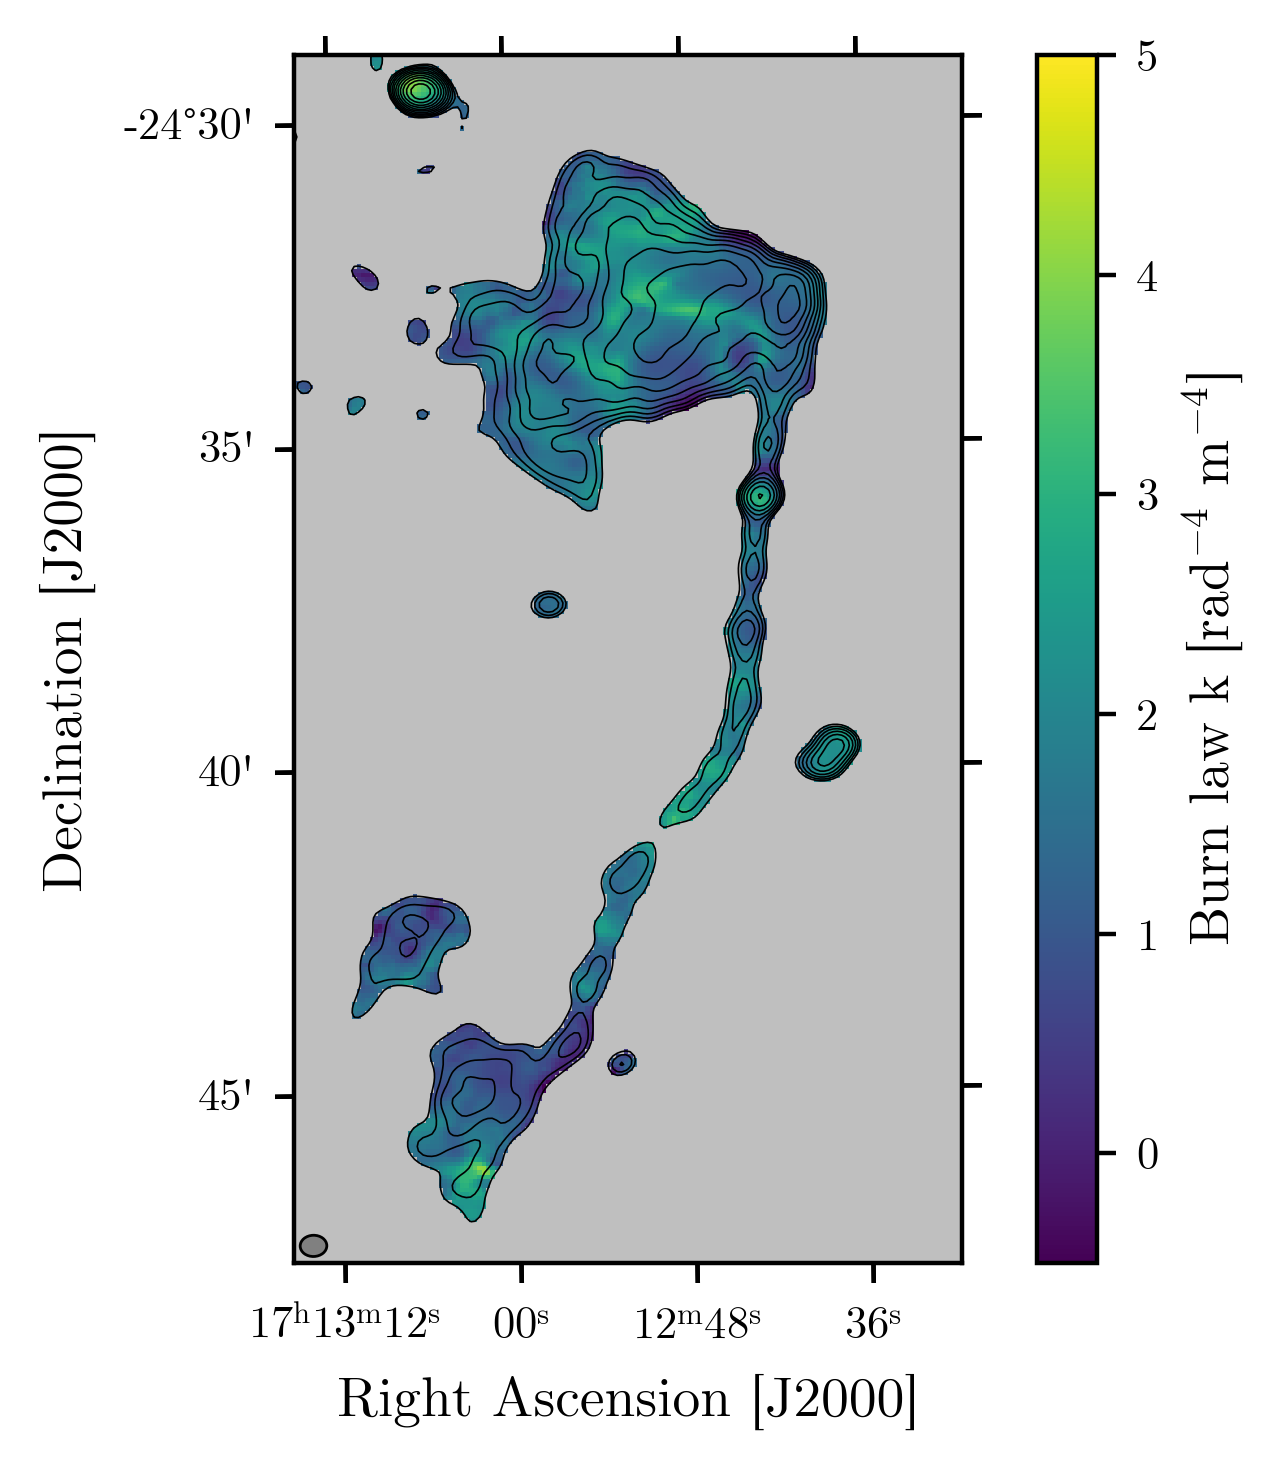

In [13]:
#fit a burn k law. Note that this can take a while!
#just so that you can switch this off if you're running the whole notebook and you don't want it
burn=True
if burn:
    if os.path.isfile(directory+'burnkfit.fits')==False:
        k_arr,p0_arr,burnredchi=burnkfit(lamdasq,polfrac_cube,polfrac_cube_errs,cont_mask.mask)
        writeburn=True
        if writeburn==True:
            print("Saving the burn map")
            hdu = fits.PrimaryHDU(k_arr,header=pkrm_fit_header)
            hdu.writeto(directory+'burnkfit.fits')
            
    else:
        k_arr,khead=fitsopen(directory+'burnkfit.fits')
    plt.figure(dpi= 400)
    ax=plt.subplot(projection=wcs)
    c=ax.imshow(k_arr, origin='lower', cmap=viridis,vmin=-0.5,vmax=5)
    ax.contour(cont_im,levels=i_contours,colors='black')
    plt.xlabel('Right Ascension [J2000]')
    plt.ylabel('Declination [J2000]')
    ellipse= Ellipse(xy=(posx,posy),width=bmaj_pix,height=bmin_pix,angle=bpa+90,edgecolor='black',fc='gray',lw=0.5)
    ax.add_patch(ellipse)
    cbar=plt.colorbar(c,fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel(r'Burn law k [rad$^{-4}$ m$^{-4}$]')
    plt.gca().set_aspect("equal")
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    if savefigs:
        plt.savefig(fig_directory+src+'burnk.png',dpi=400,bbox_inches='tight',transparent=True)
        plt.savefig(directory+src+'burnk.png',dpi=400,bbox_inches='tight',transparent=True)  
    plt.show()
    

[510 521 532 543 554 565 576 587 598]
0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


<Figure size 432x288 with 0 Axes>

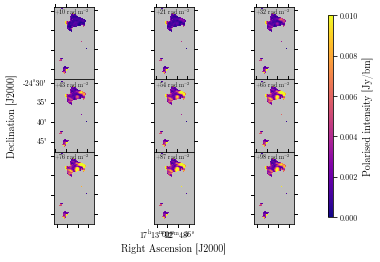

In [15]:
#statistical plots

indices=np.indices(dimensions=pkrm_fit_masked.shape)
xcoords=indices[1,:,:]
ycoords=indices[0,:,:]

#plt.figure()
#plt.imshow(pkrm_fit_masked,origin='lower',vmin=0,vmax=100)
#plt.show()


#CHANGE THE VALUES BELOW FOR EACH SOURCE


box=np.where(ycoords>=ymin,1,0)*np.where(ycoords<=ymax,1,0)*np.where(xcoords<=xmax,1,0)*np.where(xcoords>=xmin,1,0)

leftlobe_loc=np.where(ycoords>=190,1,0)*box
rightlobe_loc=np.where(ycoords<=190,1,0)*box

#rotation measures
leftlobe_rm=np.where(leftlobe_loc>=1,pkrm_fit_masked,np.nan)
rightlobe_rm=np.where(rightlobe_loc>=1,pkrm_fit_masked,np.nan)
#dnno why we need to mask again but here we are
leftlobe_rm=np.ma.masked_where(cont_pol_mask.mask==True,leftlobe_rm)
rightlobe_rm=np.ma.masked_where(cont_pol_mask.mask==True,rightlobe_rm)

leftlobe_depol=np.where(leftlobe_loc>=1,polfrac_change_masked,np.nan)
rightlobe_depol=np.where(rightlobe_loc>=1,polfrac_change_masked,np.nan)
#dnno why we need to mask again but here we are
leftlobe_depol=np.ma.masked_where(cont_pol_mask.mask==True,leftlobe_depol)
rightlobe_depol=np.ma.masked_where(cont_pol_mask.mask==True,rightlobe_depol)

karr_left=np.where(leftlobe_loc>=1,k_arr,np.nan)
karr_right=np.where(rightlobe_loc>=1,k_arr,np.nan)

karr_left=np.ma.masked_where(cont_pol_mask.mask==True,karr_left)
karr_right=np.ma.masked_where(cont_pol_mask.mask==True,karr_right)


leftmean_rm=np.nanmean(leftlobe_rm)
rightmean_rm=np.nanmean(rightlobe_rm)
leftstd_rm=np.nanstd(leftlobe_rm)
rightstd_rm=np.nanstd(rightlobe_rm)

print(leftmean_rm,leftstd_rm)
print(rightmean_rm,rightstd_rm)
npix_left=len(leftlobe_rm[np.isfinite(leftlobe_rm)])
npix_right=len(rightlobe_rm[np.isfinite(rightlobe_rm)])
print(npix_left)
print(npix_right)



62.98080800596968 116.03232931447278
30.403192758270396 621.8414509772983
3378
1278


[ 0.  4.  5.  4.  3.  1.  2.  1.  5.  0.  3.  1.  1.  1.  0.  0.  0.  0.
  2.  1.  2.  0.  1.  1.  2.  0.  1.  1.  0.  0.  0.  0.  3.  2.  1.  4.
  3.  2.  2.  1.  2.  2.  0.  3.  0.  4.  2.  1.  2.  5.  0.  2.  2.  3.
  0.  3.  4.  2.  4.  7. 14. 16. 28. 17. 16. 19. 35. 32. 43. 39. 45. 50.
 29. 15. 11. 12. 11. 17. 16. 30. 31. 27. 49. 33. 14. 10.  6. 14.]
<function fit at 0x10d42d5e0>
right
71.24414905895513 19.752579013129836
ShapiroResult(statistic=0.7087336778640747, pvalue=6.39171181260334e-12)
left
72.83217351730622 4.374055300320691
ShapiroResult(statistic=0.4344349503517151, pvalue=9.143604860324415e-17)


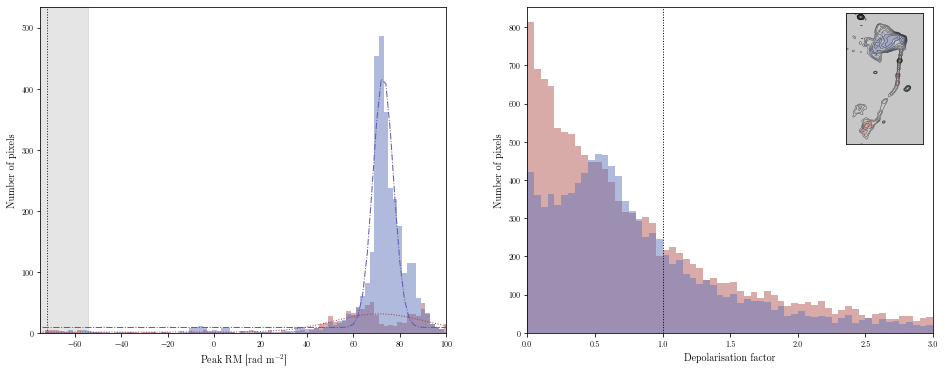

In [16]:


#histogram(s)
rm_min=-75
rm_max=100

binsize=2
rm_scale_bins=binsize*np.ceil(np.nanmax(np.nanmax(np.abs(pkrm_fit_masked)))/binsize)
#bins_array=np.arange(start=-rm_scale_bins,stop=rm_scale_bins,step=binsize)
bins_array=np.arange(start=rm_min,stop=rm_max+binsize,step=binsize)
bincentres=bins_array[0:-1]+(binsize/2.)

fig, (ax,ax2) = plt.subplots(1,2,figsize=[16, 6])
kwargs = dict(histtype='stepfilled', alpha=0.5, bins=bins_array,linewidth=1)
rmhist_right=ax.hist(np.ndarray.flatten(rightlobe_rm),**kwargs,color=twilight(0.75))
rmhist_left=ax.hist(np.ndarray.flatten(leftlobe_rm),**kwargs,color=twilight(0.25))
ymax_pix=1.1*np.nanmax([rmhist_right[0],rmhist_left[0]])
ax.set_xlim(rm_min,rm_max)
ax.set_ylim(0,ymax_pix)
ax.set_xlabel(r'Peak RM [rad m$^{-2}$]')
ax.set_ylabel(r'Number of pixels')
ax.axvline(x=galacticRM,color=twilight(0.5),linestyle=':',linewidth=1,label='Galactic RM')
ax.fill_betweenx([0,ymax_pix],x1=galacticRM-gRMerr, x2=galacticRM+gRMerr,color='grey',alpha=0.2)
#axins = ax.inset_axes([0.03, 0.70, 0.33, 0.33]) #j1705


print(rmhist_right[0])
H, A, x0, sigma=gaussfit(bincentres,rmhist_right[0])
print(fit)
print('right')
print(x0, sigma)
shapiro_right = stats.shapiro(rmhist_right[0])
print(shapiro_right)
gaussian= H + A*np.exp(-(np.subtract(x0,bincentres) ** 2 / (2 * sigma ** 2)))
ax.plot(bincentres,gaussian,color=twilight(0.7),lw=1,linestyle=':')
H, A, x0, sigma=gaussfit(bincentres,rmhist_left[0])
shapiro_left = stats.shapiro(rmhist_left[0])
print('left')
print(x0, sigma)
print(shapiro_left)
gaussian= H + A*np.exp(-(np.subtract(x0,bincentres) ** 2 / (2 * sigma ** 2)))
ax.plot(bincentres,gaussian,color=twilight(0.3),lw=1,linestyle='-.')

bins2=np.arange(start=0,stop=3.1,step=0.05)

kwargs2 = dict(histtype='stepfilled', alpha=0.5,bins=bins2,linewidth=1)
ax2.hist(np.ndarray.flatten(rightlobe_depol),**kwargs2,color=twilight(0.75),label='Right lobe')
ax2.hist(np.ndarray.flatten(leftlobe_depol),**kwargs2,color=twilight(0.25),label='Left lobe')
ax2.set_xlim(0,3)
ax2.set_xlabel(r'Depolarisation factor')
ax2.set_ylabel(r'Number of pixels')
ax2.axvline(x=1,color='black',linestyle='dotted',linewidth=1)

axins = ax2.inset_axes([0.68, 0.58, 0.4, 0.4])
axins.imshow(leftlobe_rm,origin='lower',cmap=twilight,vmin=-2500,vmax=7500,alpha=0.5)
axins.imshow(rightlobe_rm,origin='lower',cmap=twilight,vmin=-7500,vmax=2500,alpha=0.5)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.set_xlim(xmin,xmax)
axins.set_ylim(ymin,ymax)
axins.contour(cont_im,levels=i_contours,colors='black',linewidth=0.1)
axins.set_xticks([])
axins.set_yticks([])

#ax2.legend(loc="upper right")
plt.savefig(fig_directory+src+'hist_seplobes_2.png',dpi=600,bbox_inches='tight',transparent=True)
plt.show()

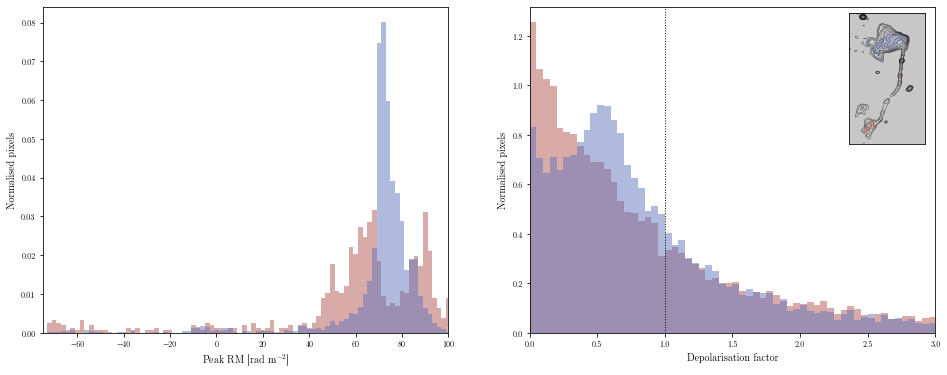

In [17]:
#proportion of pixels
fig, (ax,ax2) = plt.subplots(1,2,figsize=[16, 6])
kwargs = dict(histtype='stepfilled', alpha=0.5, bins=bins_array,linewidth=1)
norm_rmhist_right=ax.hist(np.ndarray.flatten(rightlobe_rm),density=True,**kwargs,color=twilight(0.75))
norm_rmhist_left=ax.hist(np.ndarray.flatten(leftlobe_rm),density=True,**kwargs,color=twilight(0.25))
ax.set_xlim(rm_min,rm_max)
ax.set_xlabel(r'Peak RM [rad m$^{-2}$]')
ax.set_ylabel(r'Normalised pixels')

kwargs2 = dict(histtype='stepfilled', alpha=0.5,bins=bins2,linewidth=1)
ax2.hist(np.ndarray.flatten(rightlobe_depol),density=True,**kwargs2,color=twilight(0.75),label='Right lobe')
ax2.hist(np.ndarray.flatten(leftlobe_depol),density=True,**kwargs2,color=twilight(0.25),label='Left lobe')
ax2.set_xlim(0,3)
ax2.set_xlabel(r'Depolarisation factor')
ax2.set_ylabel(r'Normalised pixels')
ax2.axvline(x=1,color='black',linestyle='dotted',linewidth=1)

axins = ax2.inset_axes([0.68, 0.58, 0.4, 0.4])
axins.imshow(leftlobe_rm,origin='lower',cmap=twilight,vmin=-2500,vmax=7500,alpha=0.5)
axins.imshow(rightlobe_rm,origin='lower',cmap=twilight,vmin=-7500,vmax=2500,alpha=0.5)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.set_xlim(xmin,xmax)
axins.set_ylim(ymin,ymax)
axins.contour(cont_im,levels=i_contours,colors='black',linewidth=0.1)
axins.set_xticks([])
axins.set_yticks([])

#ax2.legend(loc="upper right")
#plt.savefig(fig_directory+src+'hist_seplobes_density_2.png',dpi=600,bbox_inches='tight',transparent=True)
plt.show()

right 71.46361308272127 19.87975102326653
left 72.8209601413401 4.339434398847795


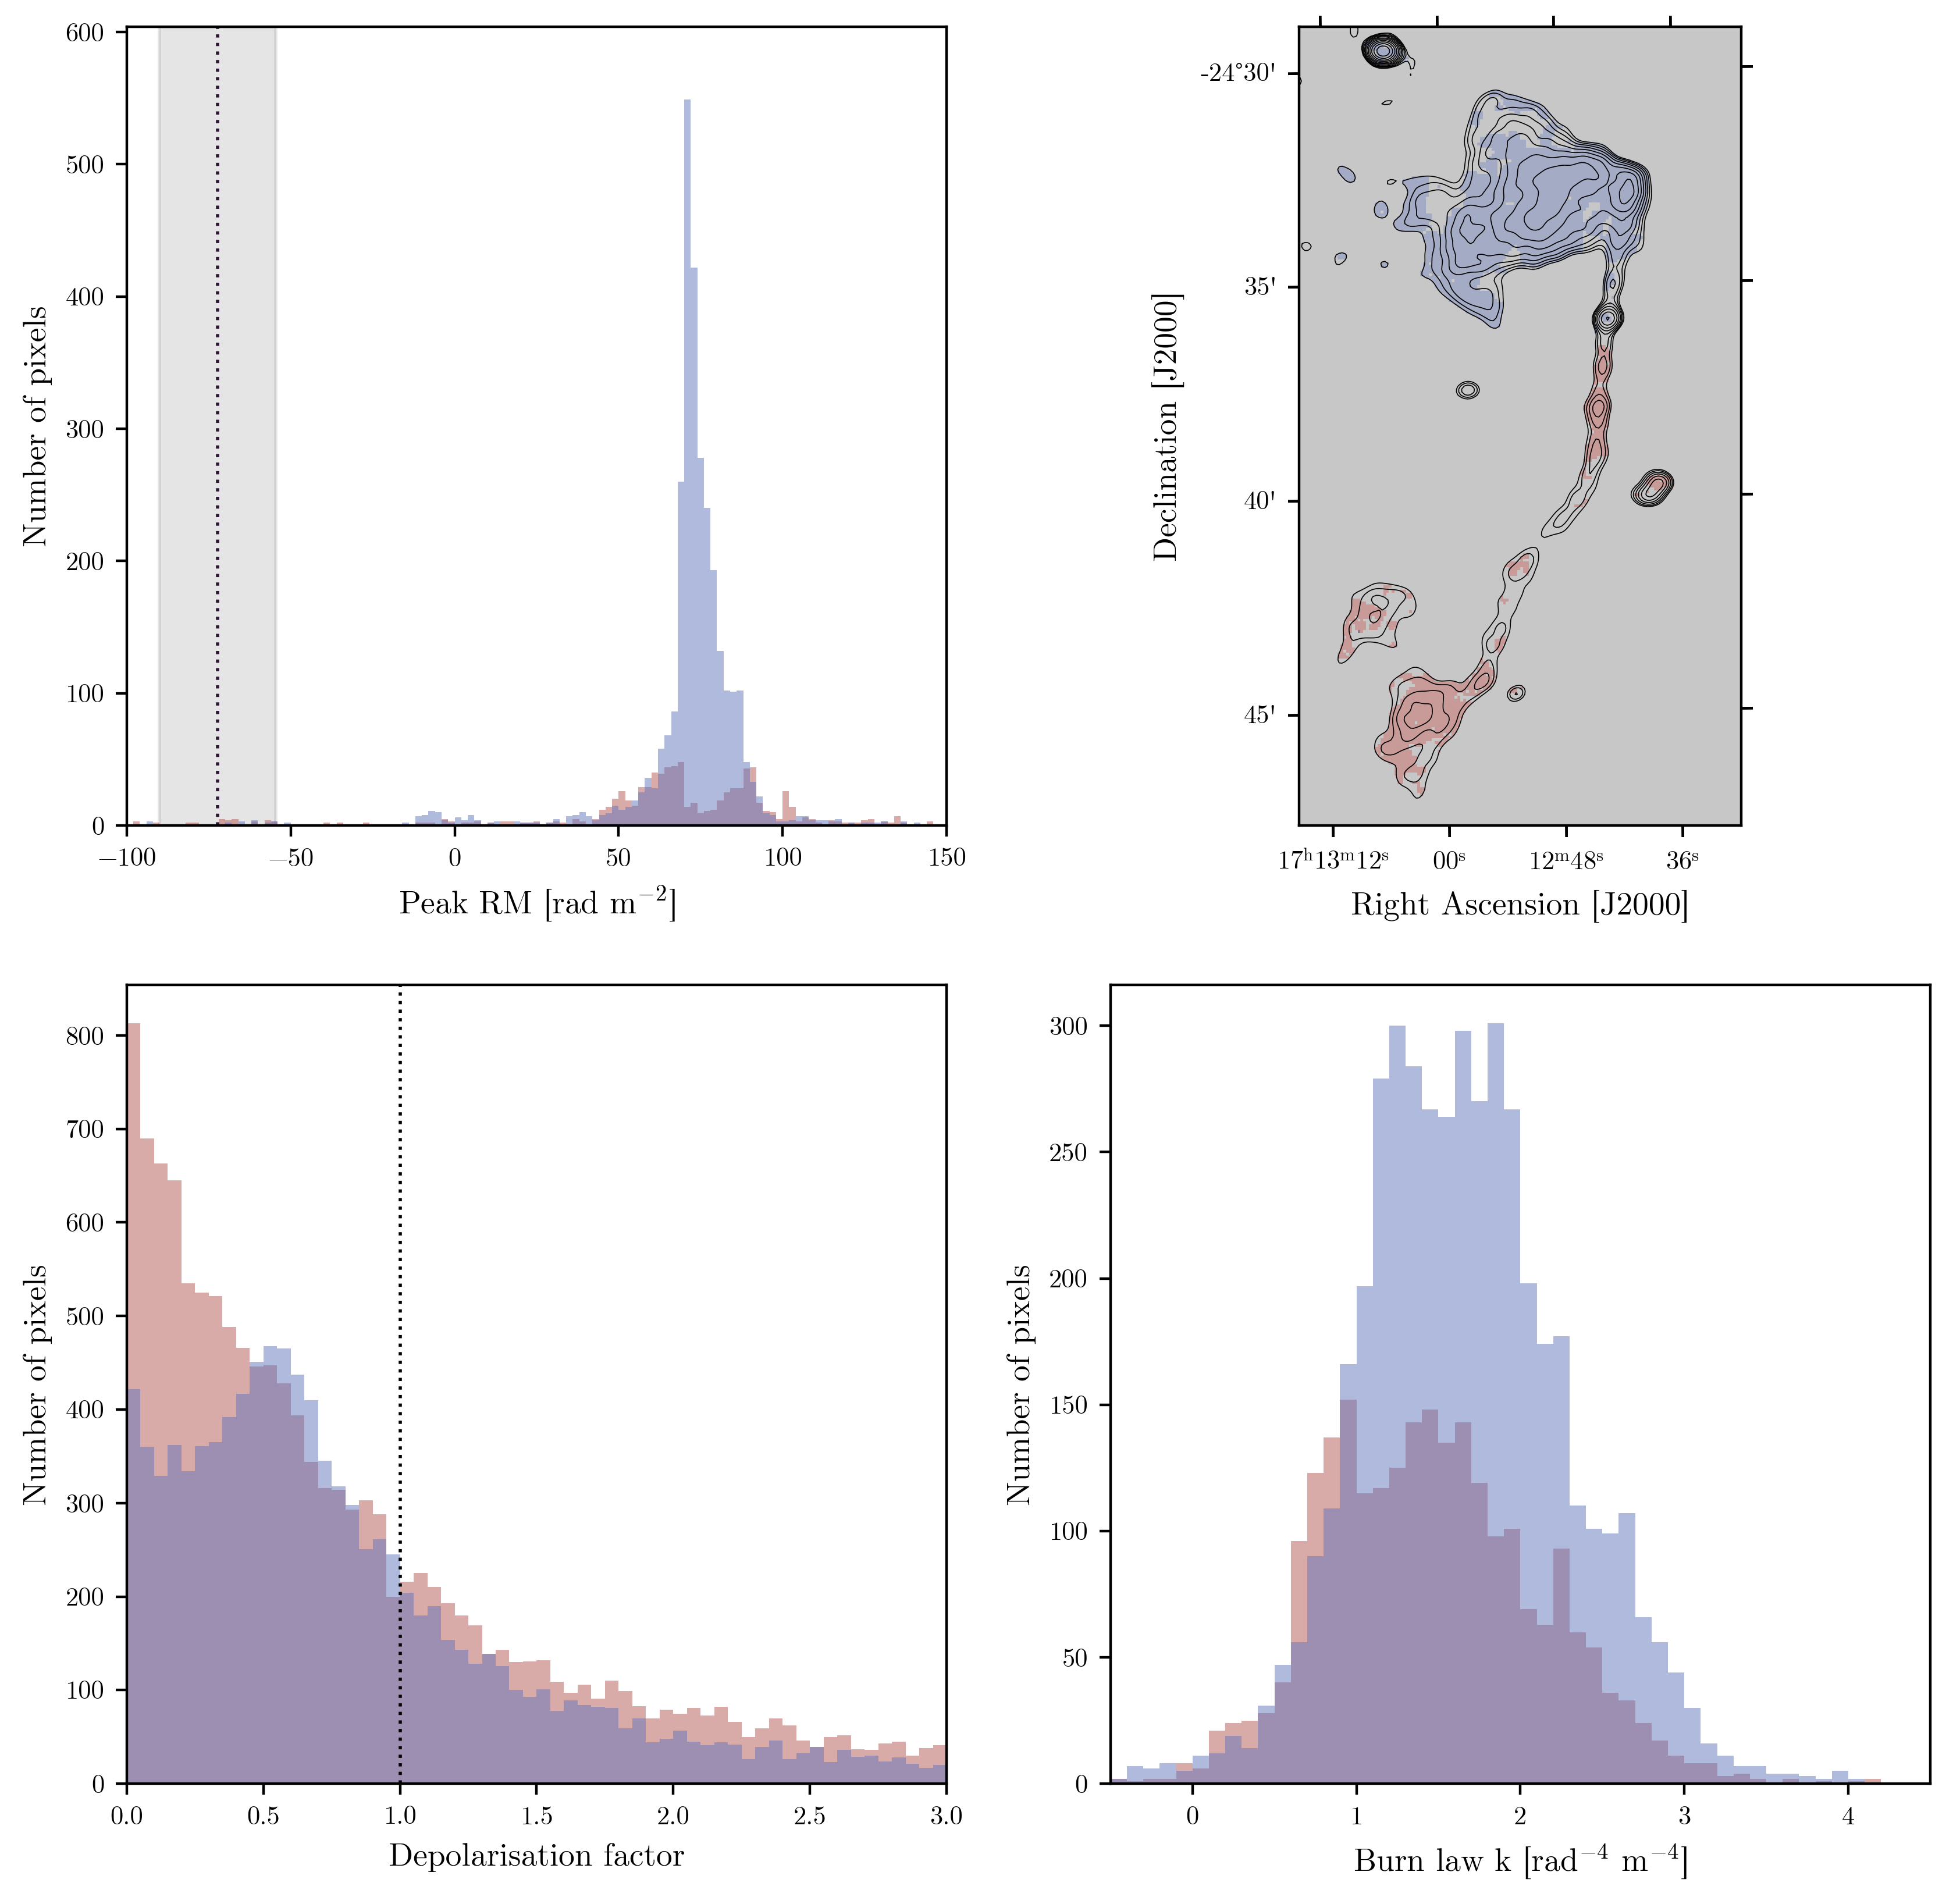

In [73]:
#histogram(s)
rm_min=-100
rm_max=150

binsize=2
rm_scale_bins=binsize*np.ceil(np.nanmax(np.nanmax(np.abs(pkrm_fit_masked)))/binsize)
#bins_array=np.arange(start=-rm_scale_bins,stop=rm_scale_bins,step=binsize)
bins_array=np.arange(start=rm_min,stop=rm_max+binsize,step=binsize)
bincentres=bins_array[0:-1]+(binsize/2.)

fig=plt.figure(dpi=400,figsize=(10,10))
# map of the average polarisd intensity around example pixel
ax=plt.subplot(221,adjustable='box')
kwargs = dict(histtype='stepfilled', alpha=0.5, bins=bins_array,linewidth=1)
rmhist_right=ax.hist(np.ndarray.flatten(rightlobe_rm),**kwargs,color=twilight(0.75))
rmhist_left=ax.hist(np.ndarray.flatten(leftlobe_rm),**kwargs,color=twilight(0.25))
ymax_pix=1.1*np.nanmax([rmhist_right[0],rmhist_left[0]])
ax.set_xlim(rm_min,rm_max)
ax.set_ylim(0,ymax_pix)
ax.set_xlabel(r'Peak RM [rad m$^{-2}$]')
ax.set_ylabel(r'Number of pixels')
ax.axvline(x=galacticRM,color=twilight(0.5),linestyle=':',linewidth=1,label='Galactic RM')
ax.fill_betweenx([0,ymax_pix],x1=galacticRM-gRMerr, x2=galacticRM+gRMerr,color='grey',alpha=0.2)
#axins = ax.inset_axes([0.03, 0.70, 0.33, 0.33]) #j1705

plotx=np.arange(start=rm_min,stop=rm_max+(binsize/10.),step=binsize/10.)

H, A, x0, sigma=gaussfit(bincentres,rmhist_right[0])
print("right",x0,sigma)
shapiro_right = stats.shapiro(rmhist_right[0])
gaussian= H + A*np.exp(-(np.subtract(x0,plotx) ** 2 / (2 * sigma ** 2)))
#ax.plot(plotx,gaussian,color=twilight(0.7),lw=0.5,linestyle=':')
H, A, x0, sigma=gaussfit(bincentres,rmhist_left[0])
shapiro_left = stats.shapiro(rmhist_left[0])
gaussian= H + A*np.exp(-(np.subtract(x0,plotx) ** 2 / (2 * sigma ** 2)))
#ax.plot(plotx,gaussian,color=twilight(0.3),lw=0.5,linestyle='-.')
print("left",x0,sigma)

bins2=np.arange(start=0,stop=3.1,step=0.05)
ax3=plt.subplot(223,adjustable='box')

kwargs2 = dict(histtype='stepfilled', alpha=0.5,bins=bins2,linewidth=1)
dphist1=ax3.hist(np.ndarray.flatten(rightlobe_depol),**kwargs2,color=twilight(0.75),label='Right lobe')
dphist2=ax3.hist(np.ndarray.flatten(leftlobe_depol),**kwargs2,color=twilight(0.25),label='Left lobe')
ax3.set_xlim(0,3)
ax3.set_xlabel(r'Depolarisation factor')
ax3.set_ylabel(r'Number of pixels')
ax3.axvline(x=1,color='black',linestyle='dotted',linewidth=1)

ax2=plt.subplot(222,adjustable='box',projection=wcs)
ax2.imshow(leftlobe_rm,origin='lower',cmap=twilight,vmin=-25000,vmax=75000,alpha=0.5)
ax2.imshow(rightlobe_rm,origin='lower',cmap=twilight,vmin=-75000,vmax=25000,alpha=0.5)
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)
#ax2.set_xlim(xmin+15,xmax+5)
#ax2.set_ylim(ymax-(xmax-xmin)+10,ymax)
ax2.contour(cont_im,levels=i_contours,colors='black',linewidth=0.1)
ax2.set_xlabel('Right Ascension [J2000]')
ax2.set_ylabel('Declination [J2000]')

ax4=plt.subplot(224,adjustable='box')
kbins=np.arange(start=-1,stop=5,step=0.1)
k_hist1=ax4.hist(np.ndarray.flatten(karr_right),color=twilight(0.75),bins=kbins,alpha=0.5)
k_hist2=ax4.hist(np.ndarray.flatten(karr_left),color=twilight(0.25),bins=kbins,alpha=0.5)
ax4.set_ylabel(r'Number of pixels')
ax4.set_xlabel(r'Burn law k [rad$^{-4}$ m$^{-4}$]')
ax4.set_xlim(-0.5,4.5)
plt.savefig(fig_directory+src+'_allhists.png',dpi=600,bbox_inches='tight',transparent=True)
plt.show()

In [63]:
stat=stats.ks_2samp(np.ndarray.flatten(karr_right),np.ndarray.flatten(karr_left))
print(stat)
print(np.nanmean(karr_right))
print(np.nanmean(karr_left))
print(np.nanstd(karr_right))
print(np.nanstd(karr_left))

KstestResult(statistic=0.30154378877506854, pvalue=2.0476277199896487e-278)
1.2925176625807788
1.6132887117015533
0.5986419770001524
0.6363502484903458


In [71]:
stat=stats.ks_2samp(np.ndarray.flatten(leftlobe_rm),np.ndarray.flatten(rightlobe_rm))
print(stat)
print(np.nanmean(rightlobe_rm))
print(np.nanmean(leftlobe_rm))
print(np.nanstd(rightlobe_rm))
print(np.nanstd(leftlobe_rm))

right_rmcut=rightlobe_rm[rightlobe_rm>=rm_min]
right_rmcut=right_rmcut[right_rmcut<=rm_max]
left_rmcut=leftlobe_rm[leftlobe_rm>=rm_min]
left_rmcut=left_rmcut[left_rmcut<=rm_max]
print("eeble deeble")
print(np.nanmean(right_rmcut))
print(np.nanmean(left_rmcut))
print(np.nanstd(right_rmcut))
print(np.nanstd(left_rmcut))


KstestResult(statistic=0.32001154234598184, pvalue=3.793905732e-314)
30.403192758270396
62.98080800596968
621.8414509772983
116.03232931447278
eeble deeble
63.887004750628385
71.0880359523181
41.4709091913705
21.07698635734345


In [65]:
stat=stats.ks_2samp(np.ndarray.flatten(rightlobe_depol),np.ndarray.flatten(leftlobe_depol))
print(stat)
print(np.nanmean(rightlobe_depol))
print(np.nanmean(leftlobe_depol))
print(np.nanstd(rightlobe_depol))
print(np.nanstd(leftlobe_depol))

KstestResult(statistic=0.3113547828596162, pvalue=4.088279515695777e-297)
0.9869288284432866
0.7430061826913891
23.2680247851193
6.472554031809391


Text(0, 0.5, 'p value')

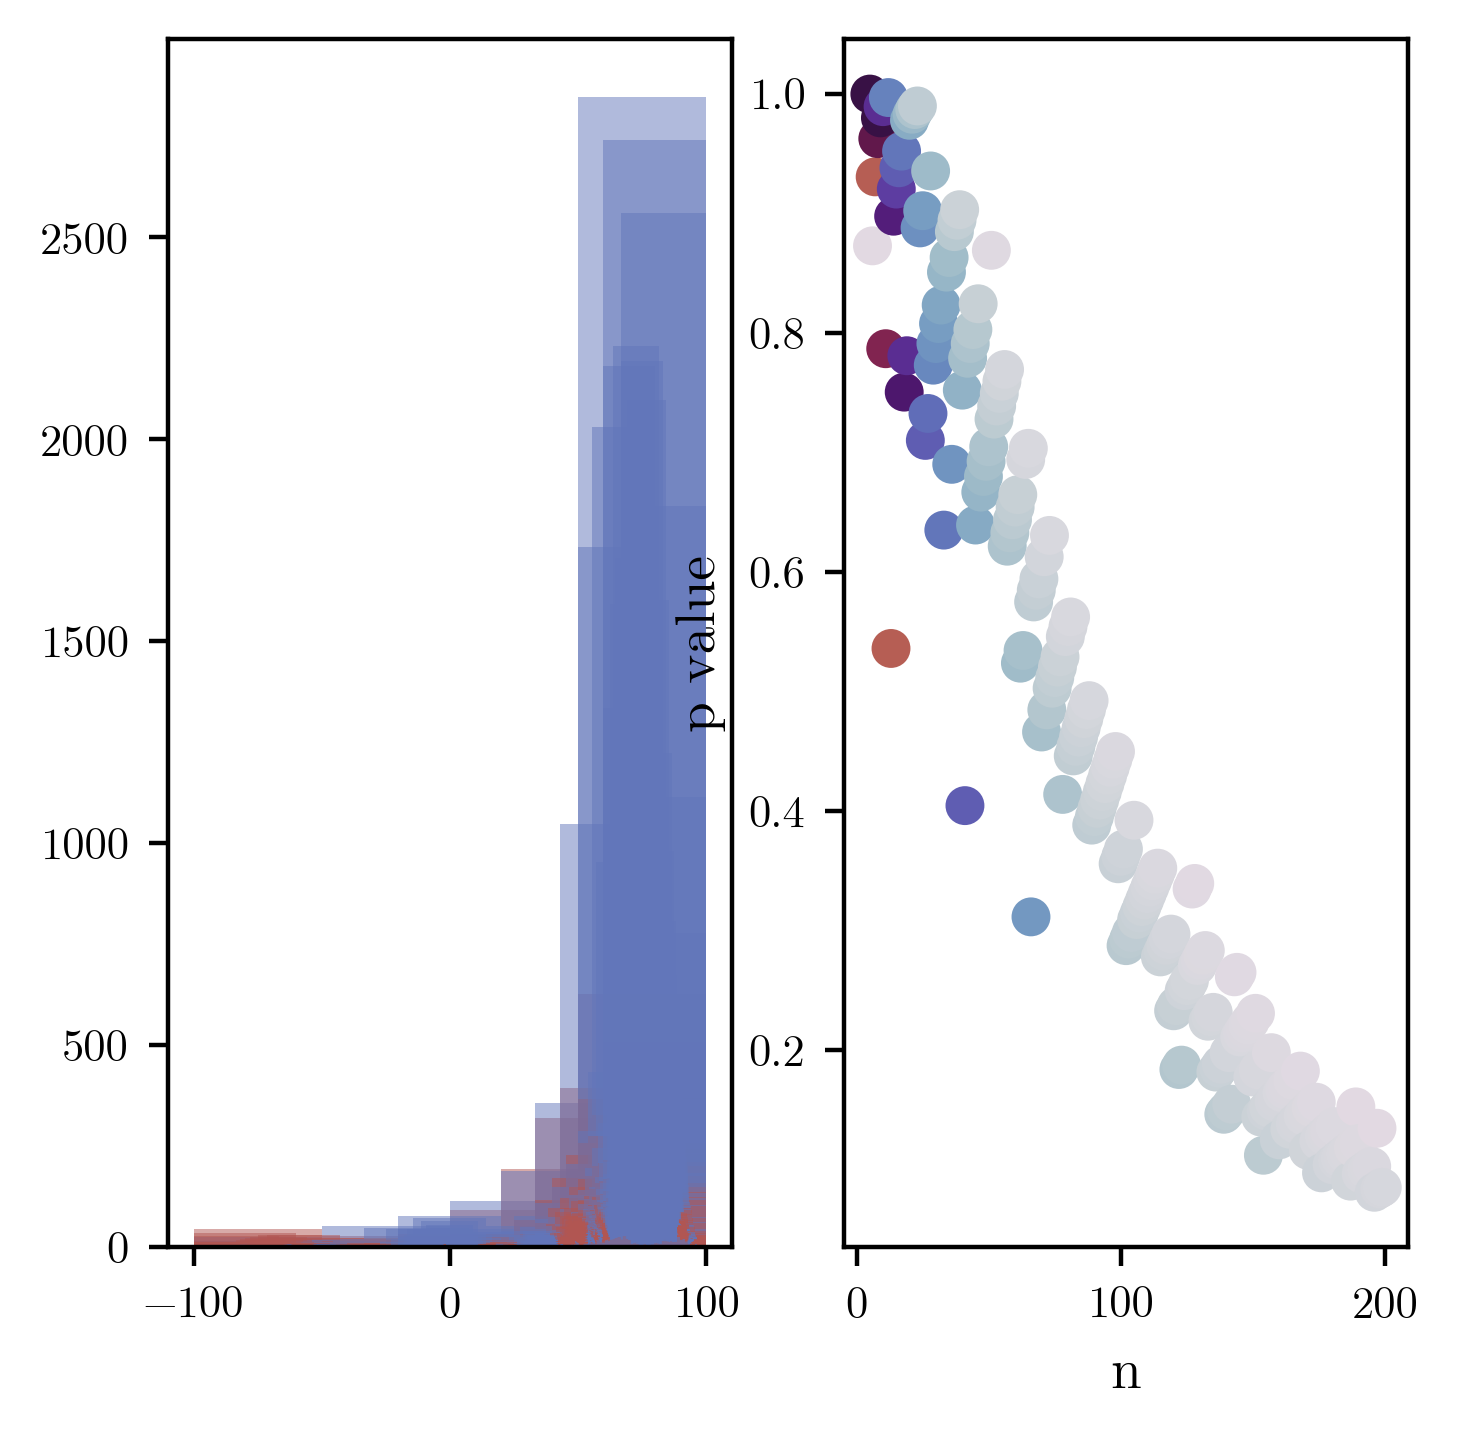

In [22]:
sa=[]
pa=[]
ia=[]
fig=plt.figure(dpi=400,figsize=(4,4))
ax1=plt.subplot(121,adjustable='box')
ax2=plt.subplot(122,adjustable='box')
for i in range(5,200):
    bins=np.linspace(start=-100,stop=100,num=i)
    hist1=ax1.hist(np.ndarray.flatten(rightlobe_rm),color=twilight(0.75),bins=bins,alpha=0.5)
    hist2=ax1.hist(np.ndarray.flatten(leftlobe_rm),color=twilight(0.25),bins=bins,alpha=0.5)
    s,p=stats.ks_2samp(hist1[0],hist2[0])
    sa.append(s)
    pa.append(p)
    ia.append(i)
ax2.scatter(ia,pa,c=sa,cmap=twilight)
ax2.set_xlabel('n')
ax2.set_ylabel('p value')

Text(0, 0.5, 'p value')

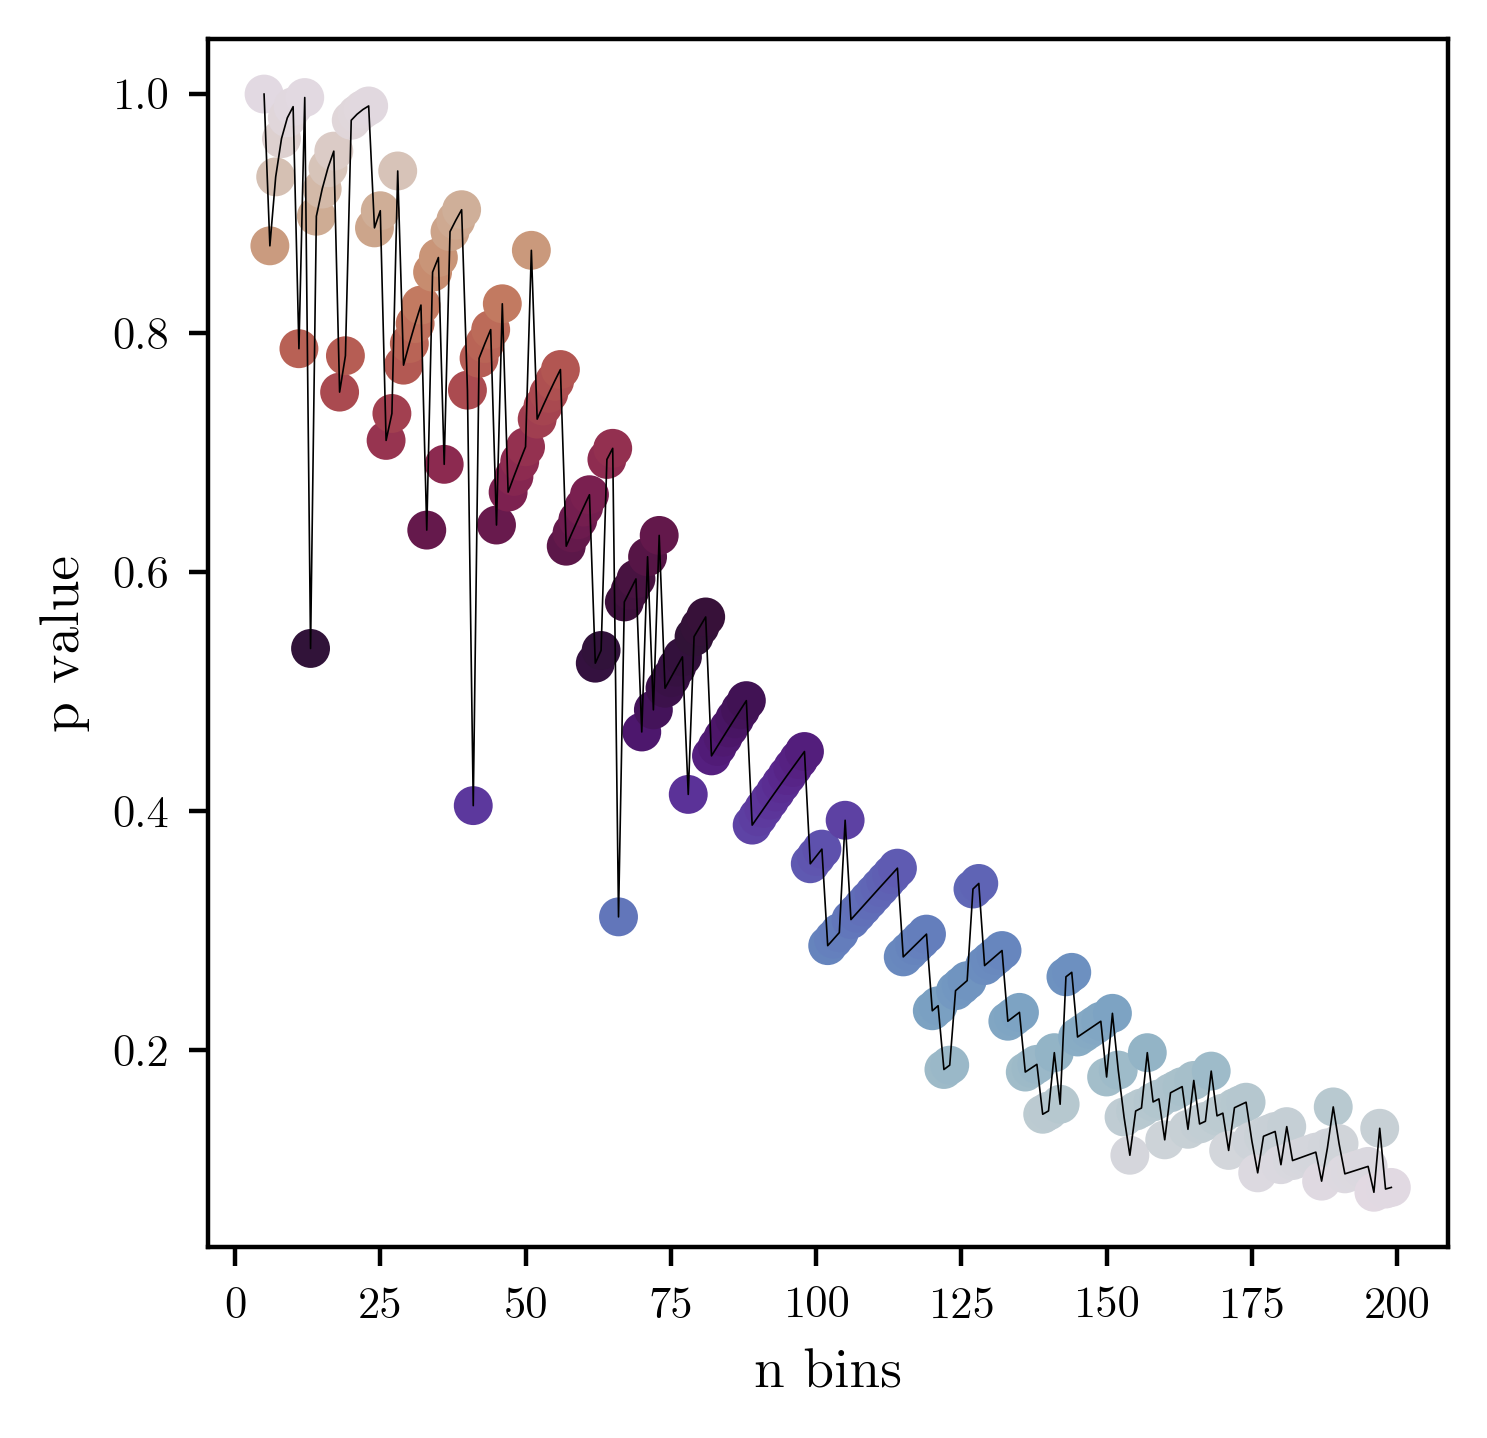

In [23]:
fig=plt.figure(dpi=400,figsize=(4,4))
plt.plot(ia,pa,color='k')
plt.scatter(ia,pa,c=pa,cmap=twilight)
plt.xlabel('n bins')
plt.ylabel('p value')

In [24]:
#print(sa)
#print(pa)
print(pa[np.argmin(pa)])
print(ia[np.argmin(pa)])

0.08105665270167199
196


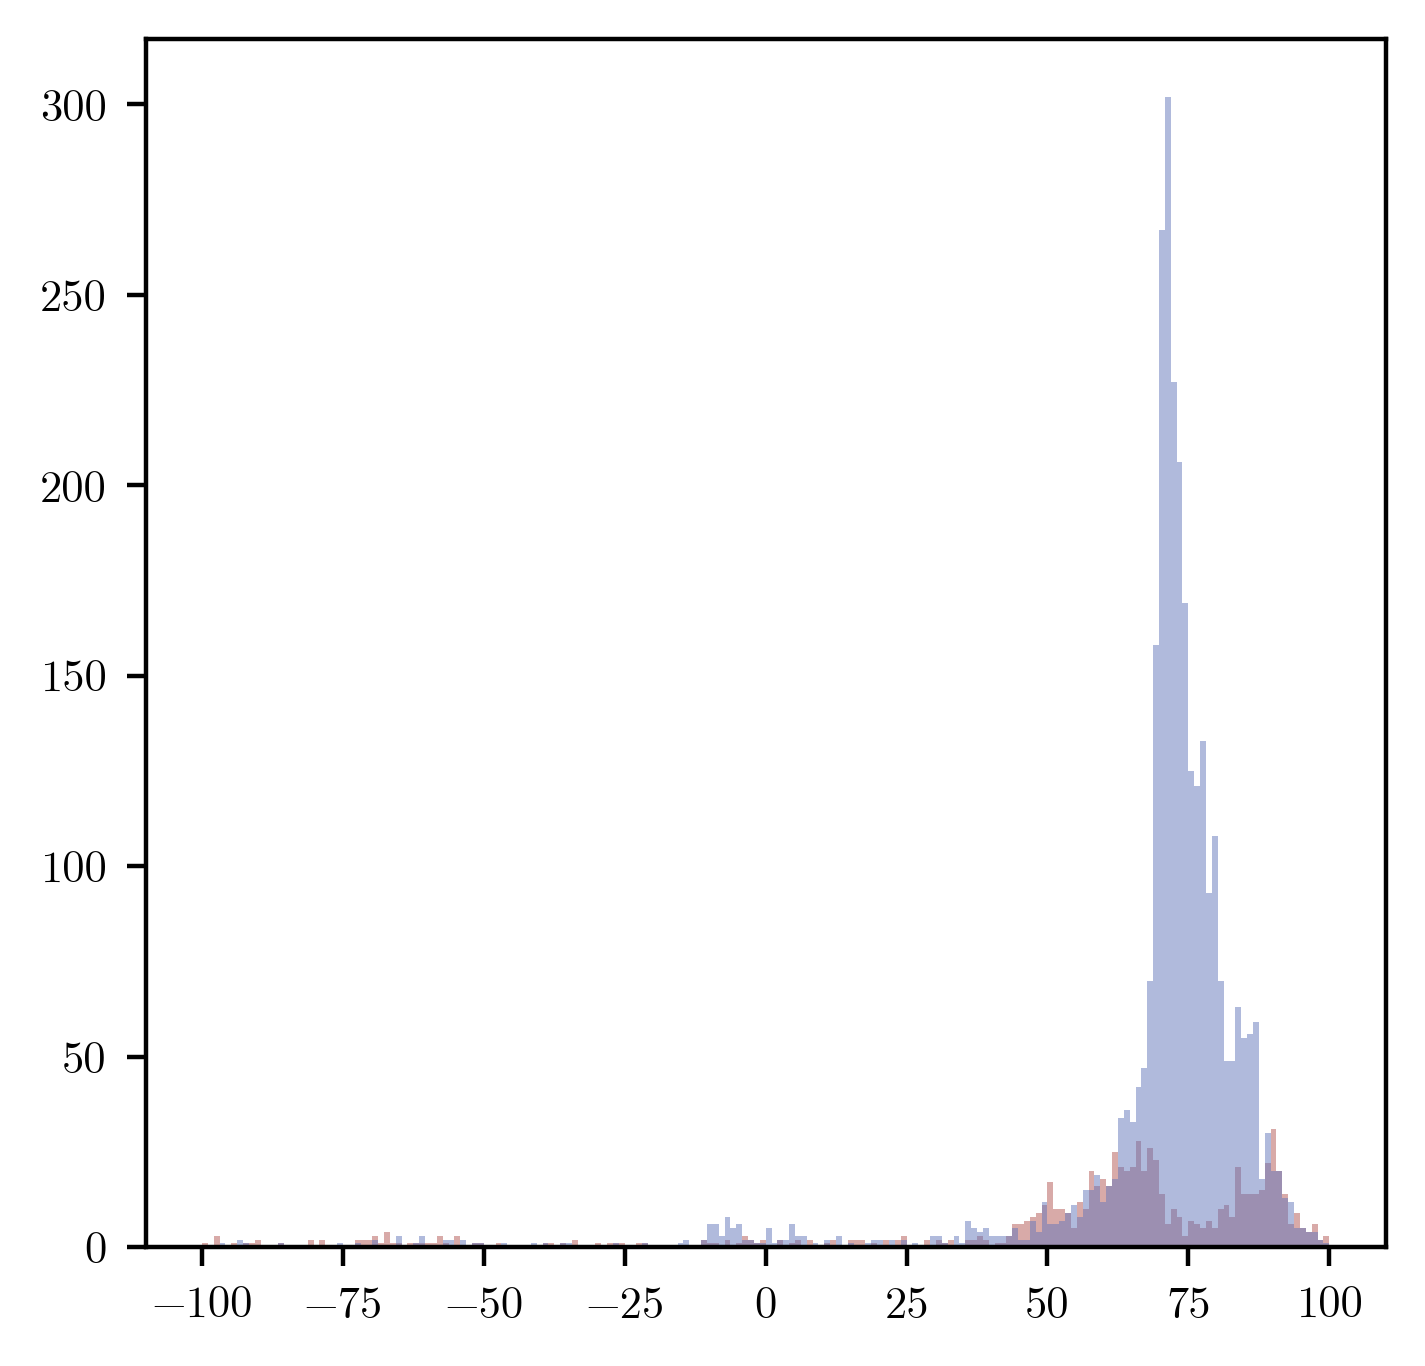

In [25]:
fig=plt.figure(dpi=400,figsize=(4,4))
ax1=plt.subplot(111,adjustable='box')
i=193
bins=np.linspace(start=-100,stop=100,num=i)
hist1=ax1.hist(np.ndarray.flatten(rightlobe_rm),color=twilight(0.75),bins=bins,alpha=0.5)
hist2=ax1.hist(np.ndarray.flatten(leftlobe_rm),color=twilight(0.25),bins=bins,alpha=0.5)
s,p=stats.ks_2samp(hist1[0],hist2[0])

In [26]:
s,p=stats.ks_2samp(np.ndarray.flatten(rightlobe_rm),np.ndarray.flatten(leftlobe_rm))
print(p)

3.793905732e-314


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


KeyboardInterrupt: 

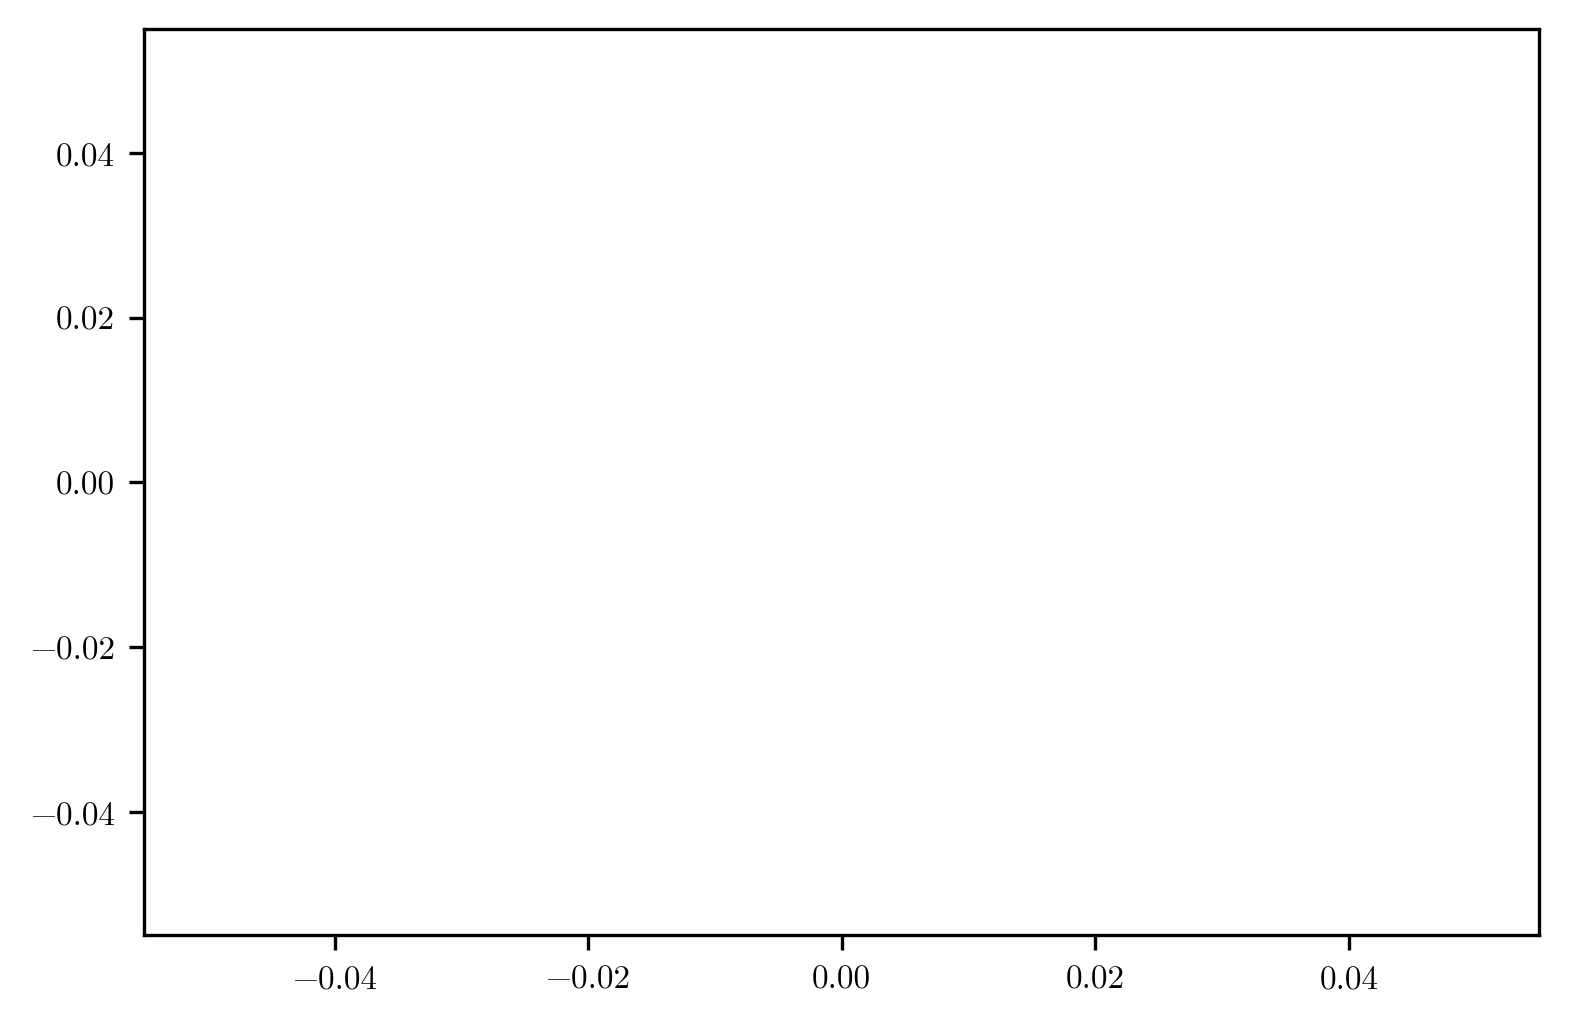

In [83]:
plt.figure(dpi=300)
#plt.scatter(np.ndarray.flatten(pkrm_fit_masked),np.ndarray.flatten(polfrac_change_masked),s=6)


for i in range(-10,10):
    minrm=i*10
    maxrm=(i+1)*10
    loc=np.where(pkrm_fit_masked>=minrm,1,0)*np.where(pkrm_fit_masked<=maxrm,1,0)
    rm=np.where(loc=1,pkrm_fit_masked,np.nan)
    pf=polfrac_change_masked[loc]
    print(np.nanmean(rm))
    print(np.nanmean(pf))
    plt.scatter(rm,pf)
plt.show()